In [14]:
import numpy as np
import cv2
import os
import pandas as pd
from collections import Counter as cnt
import matplotlib.pyplot as plt
import torch
import csv
import sys
from scipy.stats import chi2_contingency
import pickle
from scipy import stats

#import modulefmat
sys.path.append('/home/bis/230711_JSG/230602_JSG_Image/')
from Mymodule.ModelHandler import *
from Mymodule.Utils import *
from Mymodule.GradCam import *
from Mymodule.BatchHandler import *
from collections import Counter as cnt
from torchvision import transforms
from keras import Sequential
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from torch import optim

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm
from PIL import Image, ImageEnhance
from pathlib import Path

## Prepare Dataset

In [3]:
image_roots = {}
image_roots['train'] = f'./Images/Train/'
image_roots['val'] = f'./Images/Validation/'
image_roots['test'] = f'./Images/Test/' 

train_images = os.listdir(image_roots['train'])
val_images = os.listdir(image_roots['val'])
test_images  = os.listdir(image_roots['test'])                        
print(len(train_images), len(val_images), len(test_images) )
train_images[0]

381 128 128


'10601785 84 1.png'

# Test Plot

In [4]:
train_image_path1 = './Images/Train/10867708 60 1.png'
print(plt.imread(train_image_path1).shape)
#plt.figure(figsize = (7,7))
#plt.imshow(plt.imread(train_image_path1))

(381, 375, 4)


In [41]:
data['train']['image'].shape

(381, 140, 140, 3)

In [42]:
complete_data_path = "./Data/feature.pkl"

#for making dataset...
stages = ['train', 'val', 'test']
categories = ['image', 'pt_no', 'age', 'label']

"""
if os.path.isfile(complete_data_path):
    print('Data already exists')
    with open(complete_data_path, 'rb') as fr:
        data = pickle.load(fr)
"""

#else :
if 1== 1:
    data = {}
    for stage in stages: 
        data[stage] = {}
        for category in categories:
            data[stage][category] = []
            
        image_root = image_roots[stage]

        for image in tqdm(os.listdir(image_root)):
            if not image[-3:] == 'png': continue
            pt_no, age, label = image.split(' ') 
            label = label.split('.')[0]
            pt_no, age, label = pt_no, int(age), int(label)

            if label in [0,1]: 
                label = 0
            elif label in [2,3]: 
                label = 1

            image_path = os.path.join(image_root, image)
            print(cv2.imread(image_path).shape)
            reshaped_image = cv2.resize(cv2.imread(image_path), (140, 140))
            #reshaped_image = cv2.resize(cv2.imread(image_path), (299, 299))

            data[stage]['image'].append(reshaped_image)        
            data[stage]['pt_no'].append(pt_no)
            data[stage]['age'].append(age)
            data[stage]['label'].append(label)
    
        data[stage]['image'], data[stage]['age'], data[stage]['label'] = (
            np.array(data[stage]['image']), 
            np.array(data[stage]['age']), 
            np.array(data[stage]['label'])
        )

    # Save data
    with open(complete_data_path, 'wb') as fw:
        pickle.dump(data, fw)
        
print(data.keys())

  3%|▎         | 10/381 [00:00<00:04, 88.55it/s]

(342, 337, 3)
(433, 351, 3)
(294, 277, 3)
(381, 375, 3)
(362, 246, 3)
(389, 350, 3)
(173, 140, 3)
(454, 483, 3)
(345, 273, 3)
(509, 500, 3)
(276, 251, 3)
(523, 473, 3)
(456, 402, 3)
(390, 366, 3)
(393, 314, 3)
(602, 555, 3)
(673, 589, 3)


  5%|▍         | 19/381 [00:00<00:04, 77.12it/s]

(295, 277, 3)
(487, 436, 3)
(456, 358, 3)
(661, 579, 3)
(673, 528, 3)
(295, 249, 3)
(719, 759, 3)
(355, 464, 3)
(473, 685, 3)


 10%|▉         | 38/381 [00:00<00:04, 72.86it/s]

(538, 460, 3)
(180, 163, 3)
(308, 250, 3)
(244, 255, 3)
(81, 138, 3)
(293, 316, 3)
(408, 353, 3)
(598, 484, 3)
(206, 192, 3)
(360, 358, 3)
(355, 477, 3)
(579, 651, 3)
(280, 224, 3)
(673, 884, 3)
(484, 408, 3)
(280, 278, 3)
(395, 386, 3)


 12%|█▏        | 47/381 [00:00<00:04, 70.80it/s]

(362, 365, 3)
(415, 366, 3)
(428, 438, 3)
(153, 126, 3)
(206, 204, 3)
(435, 367, 3)
(472, 440, 3)
(472, 673, 3)
(704, 674, 3)
(685, 832, 3)
(401, 362, 3)


 16%|█▋        | 62/381 [00:01<00:06, 52.03it/s]

(482, 412, 3)
(722, 615, 3)
(734, 653, 3)
(311, 267, 3)
(290, 435, 3)
(461, 602, 3)
(745, 964, 3)
(460, 433, 3)
(305, 344, 3)


 22%|██▏       | 83/381 [00:01<00:04, 70.93it/s]

(231, 226, 3)
(469, 400, 3)
(404, 415, 3)
(600, 555, 3)
(376, 308, 3)
(182, 191, 3)
(357, 414, 3)
(222, 164, 3)
(530, 413, 3)
(455, 339, 3)
(378, 378, 3)
(406, 469, 3)
(294, 268, 3)
(556, 638, 3)
(417, 469, 3)
(313, 239, 3)
(318, 205, 3)
(373, 616, 3)
(457, 454, 3)
(616, 490, 3)


 25%|██▌       | 96/381 [00:01<00:03, 84.33it/s]

(438, 402, 3)
(493, 341, 3)
(215, 260, 3)
(394, 339, 3)
(265, 222, 3)
(272, 340, 3)
(286, 304, 3)
(426, 335, 3)
(463, 605, 3)
(202, 302, 3)
(346, 316, 3)
(205, 308, 3)
(484, 487, 3)
(461, 532, 3)
(205, 307, 3)
(206, 287, 3)
(208, 286, 3)
(288, 268, 3)
(393, 333, 3)
(320, 480, 3)
(514, 343, 3)
(183, 177, 3)
(381, 303, 3)
(424, 567, 3)
(372, 262, 3)
(404, 370, 3)
(168, 131, 3)
(431, 333, 3)
(462, 592, 3)
(310, 365, 3)
(315, 472, 3)
(172, 129, 3)


 33%|███▎      | 127/381 [00:01<00:02, 98.47it/s] 

(765, 806, 3)
(370, 461, 3)
(287, 393, 3)
(348, 340, 3)
(244, 287, 3)
(591, 773, 3)
(492, 551, 3)
(488, 628, 3)
(514, 597, 3)
(385, 336, 3)
(341, 387, 3)
(486, 441, 3)
(261, 217, 3)
(230, 344, 3)
(497, 359, 3)
(387, 355, 3)
(453, 363, 3)
(390, 635, 3)
(386, 346, 3)
(196, 227, 3)
(401, 299, 3)
(341, 408, 3)


 41%|████      | 156/381 [00:01<00:01, 119.69it/s]

(382, 309, 3)
(748, 622, 3)
(295, 275, 3)
(448, 345, 3)
(184, 146, 3)
(265, 239, 3)
(357, 351, 3)
(246, 177, 3)
(402, 487, 3)
(324, 301, 3)
(321, 265, 3)
(375, 361, 3)
(301, 246, 3)
(354, 298, 3)
(166, 147, 3)
(209, 223, 3)
(415, 472, 3)
(355, 268, 3)
(377, 394, 3)
(262, 422, 3)
(198, 184, 3)
(191, 204, 3)
(292, 270, 3)
(466, 362, 3)
(178, 162, 3)
(325, 359, 3)
(307, 303, 3)


 44%|████▍     | 169/381 [00:02<00:02, 100.09it/s]

(496, 674, 3)
(760, 590, 3)
(532, 708, 3)
(487, 427, 3)
(557, 642, 3)
(425, 567, 3)
(510, 408, 3)
(709, 909, 3)


 47%|████▋     | 180/381 [00:02<00:02, 75.02it/s] 

(630, 513, 3)
(642, 519, 3)
(496, 518, 3)
(378, 332, 3)
(304, 331, 3)
(651, 578, 3)
(429, 585, 3)
(415, 473, 3)
(436, 444, 3)
(249, 287, 3)
(519, 499, 3)
(423, 320, 3)


 50%|████▉     | 189/381 [00:02<00:02, 68.84it/s]

(402, 603, 3)
(721, 839, 3)
(619, 526, 3)
(175, 394, 3)
(325, 450, 3)
(457, 343, 3)
(307, 204, 3)
(464, 412, 3)
(388, 333, 3)
(462, 435, 3)
(448, 343, 3)
(566, 654, 3)


 54%|█████▍    | 205/381 [00:02<00:02, 61.36it/s]

(769, 732, 3)
(303, 316, 3)
(430, 662, 3)
(674, 773, 3)
(307, 405, 3)
(370, 371, 3)
(666, 687, 3)
(325, 391, 3)
(390, 437, 3)
(161, 345, 3)
(545, 579, 3)


 56%|█████▌    | 212/381 [00:02<00:02, 56.43it/s]

(549, 481, 3)
(705, 768, 3)
(612, 653, 3)
(453, 323, 3)
(430, 405, 3)
(348, 361, 3)
(370, 522, 3)
(346, 286, 3)
(166, 184, 3)
(329, 356, 3)
(348, 356, 3)
(470, 397, 3)
(478, 417, 3)


 61%|██████    | 231/381 [00:03<00:02, 69.89it/s]

(320, 431, 3)
(211, 279, 3)
(286, 331, 3)
(265, 301, 3)
(663, 650, 3)
(494, 439, 3)
(180, 351, 3)
(420, 452, 3)
(86, 144, 3)
(317, 318, 3)
(319, 283, 3)
(295, 318, 3)
(405, 335, 3)
(569, 529, 3)
(798, 749, 3)


 63%|██████▎   | 239/381 [00:03<00:02, 64.88it/s]

(348, 291, 3)
(369, 301, 3)
(213, 219, 3)
(580, 701, 3)
(492, 363, 3)
(431, 437, 3)
(701, 803, 3)
(676, 984, 3)
(408, 454, 3)


 66%|██████▌   | 252/381 [00:03<00:02, 56.48it/s]

(295, 265, 3)
(460, 510, 3)
(483, 514, 3)
(643, 602, 3)
(534, 712, 3)
(416, 471, 3)
(371, 416, 3)
(388, 424, 3)
(349, 380, 3)
(84, 158, 3)
(278, 281, 3)
(197, 161, 3)
(596, 558, 3)
(361, 354, 3)
(573, 578, 3)


 72%|███████▏  | 273/381 [00:03<00:01, 69.47it/s]

(368, 312, 3)
(416, 389, 3)
(408, 348, 3)
(259, 303, 3)
(420, 399, 3)
(378, 446, 3)
(467, 699, 3)
(405, 377, 3)
(215, 255, 3)
(626, 579, 3)
(476, 605, 3)
(449, 344, 3)
(698, 930, 3)
(389, 583, 3)
(311, 287, 3)
(303, 453, 3)
(257, 370, 3)
(345, 369, 3)
(381, 409, 3)
(239, 340, 3)
(205, 302, 3)
(354, 362, 3)
(282, 299, 3)


 78%|███████▊  | 299/381 [00:03<00:00, 97.10it/s]

(733, 614, 3)
(345, 271, 3)
(430, 304, 3)
(202, 303, 3)
(325, 242, 3)
(526, 571, 3)
(416, 461, 3)
(277, 292, 3)
(564, 485, 3)
(204, 303, 3)
(394, 414, 3)
(207, 310, 3)
(333, 393, 3)
(325, 424, 3)
(295, 285, 3)
(205, 287, 3)
(261, 253, 3)
(547, 547, 3)
(201, 154, 3)
(295, 250, 3)
(395, 416, 3)
(708, 555, 3)


 86%|████████▌ | 328/381 [00:04<00:00, 118.69it/s]

(310, 303, 3)
(413, 314, 3)
(302, 386, 3)
(305, 286, 3)
(246, 188, 3)
(544, 712, 3)
(253, 272, 3)
(238, 160, 3)
(292, 347, 3)
(386, 386, 3)
(437, 370, 3)
(447, 498, 3)
(279, 378, 3)
(567, 402, 3)
(218, 436, 3)
(380, 333, 3)
(340, 318, 3)
(518, 739, 3)
(355, 300, 3)
(378, 370, 3)
(143, 278, 3)
(490, 421, 3)
(514, 772, 3)
(295, 246, 3)
(379, 354, 3)
(473, 537, 3)
(386, 461, 3)
(310, 257, 3)
(391, 514, 3)
(208, 352, 3)
(469, 385, 3)
(323, 261, 3)
(454, 382, 3)
(363, 272, 3)


 96%|█████████▋| 367/381 [00:04<00:00, 142.68it/s]

(451, 415, 3)
(332, 272, 3)
(465, 438, 3)
(484, 449, 3)
(399, 374, 3)
(362, 340, 3)
(408, 347, 3)
(242, 385, 3)
(253, 223, 3)
(285, 245, 3)
(325, 325, 3)
(285, 327, 3)
(363, 363, 3)
(320, 382, 3)
(240, 287, 3)
(248, 291, 3)
(461, 380, 3)
(207, 243, 3)
(156, 347, 3)
(174, 209, 3)
(207, 319, 3)
(448, 376, 3)
(229, 333, 3)
(299, 317, 3)
(722, 615, 3)
(315, 239, 3)
(265, 264, 3)
(195, 360, 3)
(331, 392, 3)
(358, 347, 3)
(319, 253, 3)
(310, 243, 3)
(121, 264, 3)
(143, 212, 3)
(298, 267, 3)


100%|██████████| 381/381 [00:04<00:00, 83.86it/s] 


(139, 319, 3)
(146, 148, 3)
(609, 673, 3)
(612, 475, 3)
(633, 436, 3)
(192, 174, 3)
(305, 319, 3)
(601, 543, 3)


  0%|          | 0/128 [00:00<?, ?it/s]

(825, 708, 3)
(481, 502, 3)


 12%|█▏        | 15/128 [00:00<00:01, 74.90it/s]

(363, 298, 3)
(405, 431, 3)
(687, 473, 3)
(421, 479, 3)
(189, 257, 3)
(215, 180, 3)
(319, 288, 3)
(262, 269, 3)
(338, 355, 3)
(303, 348, 3)
(441, 346, 3)
(524, 699, 3)
(506, 379, 3)
(615, 594, 3)
(264, 283, 3)
(698, 767, 3)


 18%|█▊        | 23/128 [00:00<00:01, 61.43it/s]

(520, 484, 3)
(306, 308, 3)
(458, 401, 3)
(471, 401, 3)
(441, 475, 3)
(557, 533, 3)
(543, 526, 3)
(651, 520, 3)


 24%|██▍       | 31/128 [00:00<00:01, 65.25it/s]

(296, 339, 3)
(459, 555, 3)
(321, 282, 3)
(166, 167, 3)
(350, 520, 3)
(431, 473, 3)


 31%|███▏      | 40/128 [00:00<00:01, 72.89it/s]

(433, 469, 3)
(330, 351, 3)
(350, 299, 3)
(356, 434, 3)
(595, 478, 3)
(167, 158, 3)
(324, 265, 3)
(322, 276, 3)
(162, 170, 3)
(223, 168, 3)
(146, 162, 3)
(171, 147, 3)
(251, 224, 3)
(193, 187, 3)
(242, 413, 3)
(288, 260, 3)
(142, 154, 3)
(560, 792, 3)
(177, 138, 3)
(206, 181, 3)
(403, 473, 3)
(394, 472, 3)
(742, 980, 3)


 43%|████▎     | 55/128 [00:00<00:00, 85.49it/s]

(741, 785, 3)
(489, 626, 3)
(393, 282, 3)
(610, 579, 3)
(602, 756, 3)
(596, 527, 3)
(542, 615, 3)
(484, 635, 3)


 50%|█████     | 64/128 [00:00<00:01, 58.34it/s]

(612, 690, 3)
(628, 766, 3)
(630, 567, 3)


 55%|█████▌    | 71/128 [00:01<00:01, 54.78it/s]

(484, 694, 3)
(417, 367, 3)
(387, 303, 3)
(476, 481, 3)
(358, 399, 3)
(346, 321, 3)
(626, 602, 3)
(322, 351, 3)
(638, 478, 3)
(695, 886, 3)
(384, 401, 3)


 61%|██████    | 78/128 [00:01<00:01, 49.89it/s]

(694, 737, 3)
(242, 289, 3)
(537, 394, 3)
(496, 543, 3)
(383, 519, 3)
(311, 342, 3)


 69%|██████▉   | 88/128 [00:01<00:00, 59.67it/s]

(441, 386, 3)
(194, 246, 3)
(308, 303, 3)
(185, 189, 3)
(316, 245, 3)
(503, 457, 3)
(408, 338, 3)
(334, 262, 3)
(542, 545, 3)
(413, 366, 3)


 77%|███████▋  | 99/128 [00:01<00:00, 68.49it/s]

(307, 378, 3)
(282, 376, 3)
(341, 347, 3)
(393, 386, 3)
(508, 602, 3)
(476, 566, 3)
(438, 450, 3)
(586, 732, 3)
(598, 602, 3)
(496, 662, 3)
(366, 447, 3)


 84%|████████▎ | 107/128 [00:01<00:00, 56.16it/s]

(688, 638, 3)
(507, 464, 3)
(493, 473, 3)
(339, 390, 3)
(422, 396, 3)
(366, 341, 3)


 91%|█████████▏| 117/128 [00:01<00:00, 63.64it/s]

(457, 532, 3)
(202, 219, 3)
(190, 173, 3)
(183, 205, 3)
(398, 487, 3)
(470, 438, 3)
(500, 397, 3)
(354, 317, 3)
(571, 612, 3)


100%|██████████| 128/128 [00:01<00:00, 64.57it/s]


(538, 445, 3)
(293, 303, 3)
(389, 366, 3)
(438, 520, 3)
(561, 479, 3)
(358, 537, 3)
(456, 438, 3)
(179, 142, 3)


  0%|          | 0/128 [00:00<?, ?it/s]

(494, 500, 3)
(262, 376, 3)


  7%|▋         | 9/128 [00:00<00:01, 87.44it/s]

(365, 443, 3)
(518, 454, 3)
(168, 214, 3)
(453, 378, 3)
(383, 423, 3)
(333, 295, 3)
(390, 372, 3)
(456, 443, 3)
(392, 312, 3)
(327, 285, 3)
(312, 299, 3)
(550, 527, 3)
(198, 163, 3)
(420, 300, 3)


 26%|██▌       | 33/128 [00:00<00:00, 173.99it/s]

(295, 338, 3)
(292, 305, 3)
(208, 311, 3)
(484, 522, 3)
(339, 380, 3)
(484, 473, 3)
(334, 372, 3)
(292, 305, 3)
(351, 275, 3)
(204, 289, 3)
(331, 431, 3)
(287, 252, 3)
(218, 308, 3)
(218, 309, 3)
(491, 573, 3)
(318, 395, 3)
(352, 310, 3)
(319, 341, 3)
(363, 429, 3)
(325, 507, 3)
(477, 375, 3)
(358, 317, 3)
(326, 350, 3)
(338, 378, 3)
(408, 476, 3)


 45%|████▌     | 58/128 [00:00<00:00, 196.27it/s]

(507, 446, 3)
(626, 685, 3)
(481, 722, 3)
(415, 363, 3)
(516, 408, 3)
(325, 385, 3)
(245, 360, 3)
(482, 438, 3)
(465, 412, 3)
(333, 333, 3)
(310, 287, 3)
(208, 286, 3)
(230, 401, 3)
(165, 166, 3)
(363, 373, 3)
(348, 340, 3)
(417, 452, 3)
(433, 552, 3)
(400, 586, 3)
(376, 571, 3)
(465, 498, 3)
(363, 351, 3)
(412, 413, 3)
(423, 386, 3)
(204, 306, 3)
(249, 333, 3)
(367, 419, 3)
(332, 454, 3)
(437, 465, 3)
(431, 400, 3)
(376, 415, 3)
(354, 428, 3)
(340, 317, 3)
(514, 500, 3)
(468, 591, 3)
(666, 712, 3)


 61%|██████    | 78/128 [00:00<00:00, 175.05it/s]

(673, 548, 3)
(387, 348, 3)
(457, 418, 3)
(402, 318, 3)
(393, 393, 3)
(306, 318, 3)
(404, 461, 3)
(356, 521, 3)
(332, 308, 3)
(363, 330, 3)
(310, 295, 3)


 75%|███████▌  | 96/128 [00:00<00:00, 165.35it/s]

(371, 516, 3)
(385, 378, 3)
(372, 439, 3)
(331, 325, 3)
(295, 400, 3)
(288, 409, 3)
(338, 507, 3)
(303, 310, 3)
(431, 461, 3)
(378, 318, 3)
(325, 316, 3)
(474, 356, 3)
(416, 387, 3)
(320, 480, 3)
(363, 599, 3)
(329, 320, 3)
(363, 352, 3)
(485, 598, 3)
(340, 441, 3)
(268, 277, 3)
(476, 355, 3)
(347, 416, 3)
(257, 232, 3)
(342, 299, 3)
(527, 522, 3)
(356, 370, 3)
(516, 464, 3)
(272, 408, 3)
(272, 295, 3)
(317, 256, 3)
(371, 556, 3)
(290, 349, 3)
(431, 389, 3)


100%|██████████| 128/128 [00:00<00:00, 185.03it/s]

(378, 335, 3)
(310, 482, 3)
(329, 299, 3)
(440, 662, 3)
(314, 323, 3)
(202, 289, 3)
dict_keys(['train', 'val', 'test'])


### Model preparation

In [6]:
device = torch.device('cuda:2')

epochs = 20
milestone = [epochs-10, epochs-6]
min_epoch = 5
batch = 64
lr = 1e-4

model_name = 'vgg16'

### Training

In [10]:
#for transformation
#... clinic - learning_strategy - mri - group
#... first... without clinic.... to make model...
train_strategies = ['finetuning','fromscratch','freeze']

for model_name in ['vgg16' ,'resnet50', 'vgg19', 'resnet152']:#, 'inception']:
    for train_strategy in train_strategies:
        model_save_path = f'./Model/{model_name}_{train_strategy}.pt'

        if not os.path.isfile(model_save_path):
        #if 1 == 1 :
            train_x, val_x, test_x = data['train']['image'], data['val']['image'], data['test']['image']
            train_y, val_y, test_y  = data['train']['label'][:,None], data['val']['label'][:,None], data['test']['label'][:,None]
            
            #only use randrot, randvert, randaff...
            randrot, randvert, randaff, sharpness, brightness = [-15,15], 0.15, [0.1, 1], 2.0, 3.0
            
            train_transform = [
                transforms.RandomRotation(randrot),
                transforms.RandomVerticalFlip(p=randvert),
                transforms.RandomAffine(0, translate=randaff),
                #transforms.RandomAdjustSharpness(sharpness_factor=sharpness, p=1.0),  # 선명도 조정 확률을 1로 설정
                #transforms.ColorJitter(brightness=brightness),  # 밝기 조정
            ]
            
            train_loader = GetLoader(train_transform, train_x, train_y, batch=batch, test=False)
            val_loader = GetLoader([], val_x, val_y, batch=len(val_y), test=True)
            test_loader = GetLoader([], test_x, test_y, batch=len(test_y), test=True)      

            if train_strategy == 'finetuning'  : model = get_model(model_name, device, pretrained=True, freeze = False)
            if train_strategy == 'fromscratch' : model = get_model(model_name, device, pretrained=False, freeze = False)
            if train_strategy == 'freeze'      : model = get_model(model_name, device, pretrained=False, freeze = True)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestone)

            history_t_loss, history_loss, history_auc, history_test_auc, history_train_auc = \
            train_convnet(model, device, train_loader, val_loader, test_loader, lr, epochs, model_save_path,
            optimizer=optimizer, scheduler=scheduler, min_epoch=min_epoch, pos_weight=0, save_by='val_auc', out = True)

            bestepoch = np.argmax(history_auc[min_epoch-1:]) + min_epoch
            print("best epoch : ", bestepoch, " train auc : ",format(history_train_auc[bestepoch-1],".4f"),  " valid auc : ", format(history_auc[bestepoch-1],".4f"), "test auc : ", format(history_test_auc[bestepoch-1],".4f"))

        else : print(f'{model_name}_{train_strategy} already exists')

vgg16_finetuning already exists
vgg16_fromscratch already exists
vgg16_freeze already exists
resnet50_finetuning already exists
resnet50_fromscratch already exists
resnet50_freeze already exists
vgg19_finetuning already exists
vgg19_fromscratch already exists
vgg19_freeze already exists
resnet152_finetuning already exists
resnet152_fromscratch already exists
resnet152_freeze already exists


### Getting Probability from VGG16 & Resnet50 Model

In [11]:
output_path = './Data/output.pkl'
sig = torch.nn.Sigmoid()

if not os.path.isfile(output_path):
    output = {}
    
    for model_name in ['vgg16', 'resnet50', 'vgg19', 'resnet152']:
        output[model_name] = {}
        for train_strategy in train_strategies:
            output[model_name][train_strategy] = {}
            if model_name != 'Ensemble':
                model_save_path = f'./Model/{model_name}_{train_strategy}.pt'

                model = get_model(model_name, device, pretrained=True)    
                model.load_state_dict(torch.load(model_save_path))
                model.eval()

                train_x, val_x, test_x = data['train']['image'], data['val']['image'], data['test']['image']
                train_y, val_y, test_y = data['train']['label'], data['val']['label'], data['test']['label']

                randrot, randvert, randaff = [-15, 15], 0.15, [0.1, 1]
                train_transform = [transforms.RandomRotation(randrot), transforms.RandomVerticalFlip(p=randvert), transforms.RandomAffine(0, translate=randaff)]

                train_loader = GetLoader(train_transform, train_x, train_y, batch=batch, test=True)
                val_loader = GetLoader([], val_x, val_y, batch=len(val_y), test=True)
                test_loader = GetLoader([], test_x, test_y, batch=len(test_y), test=True)

                with torch.no_grad():
                    for stage in stages:
                        output[model_name][train_strategy][stage] = {}
                        if stage == 'train': loader = train_loader
                        if stage == 'val': loader = val_loader
                        if stage == 'test': loader = test_loader
                        check = 0
                        for image, label in loader:
                            image, label = image.to(device), label.to(device)
                            logit = model(image)
                            proba, label = sig(logit), label.float()
                            if check == 0:
                                probas, logits, labels = proba, logit, label
                            else:
                                probas = torch.cat([probas, proba])
                                logits = torch.cat([logits, logit])
                                labels = torch.cat([labels, label])
                            check += 1
                        output[model_name][train_strategy][stage]['proba'] = probas.cpu().numpy()
                        output[model_name][train_strategy][stage]['logit'] = logits.cpu().numpy()
                        output[model_name][train_strategy][stage]['label'] = labels.cpu().numpy()
                        output[model_name][train_strategy][stage]['age'] = data[stage]['age']    
    with open(output_path, 'wb') as fw:
        pickle.dump(output, fw)

elif os.path.isfile(output_path):
    with open(output_path, 'rb') as fr:
        output = pickle.load(fr)

print(output.keys())


dict_keys(['vgg16', 'resnet50', 'vgg19', 'resnet152'])


In [12]:
# Ensemble model combinations
ensemble_cases = {
    'vgg16+vgg19': ['vgg16', 'vgg19'],
    'vgg16+resnet50': ['vgg16', 'resnet50'],
    'vgg16+resnet50+vgg19': ['vgg16', 'resnet50', 'vgg19'],
    'vgg16+resnet50+vgg19+resnet152': ['vgg16', 'resnet50', 'vgg19', 'resnet152'],
}

for ensemble_name, model_list in ensemble_cases.items():
    output[ensemble_name] = {}
    for train_strategy in train_strategies:
        output[ensemble_name][train_strategy] = {}
        for stage in stages:
            output[ensemble_name][train_strategy][stage] = {}
            ensemble_proba = None

            for model_name in model_list:
                model_proba = output[model_name][train_strategy][stage]['proba'].copy()  # Create a copy of the probabilities

                if ensemble_proba is None:
                    ensemble_proba = model_proba  # Initialize with the first model's probability
                else:
                    ensemble_proba += model_proba  # Add the next model's probability

            # Average the probabilities
            ensemble_proba /= len(model_list)

            # Use the label from any of the models
            ensemble_label = output[model_list[0]][train_strategy][stage]['label']

            output[ensemble_name][train_strategy][stage]['proba'] = ensemble_proba
            output[ensemble_name][train_strategy][stage]['label'] = ensemble_label
            output[ensemble_name][train_strategy][stage]['age'] = data[stage]['age']

### Assessment with figures

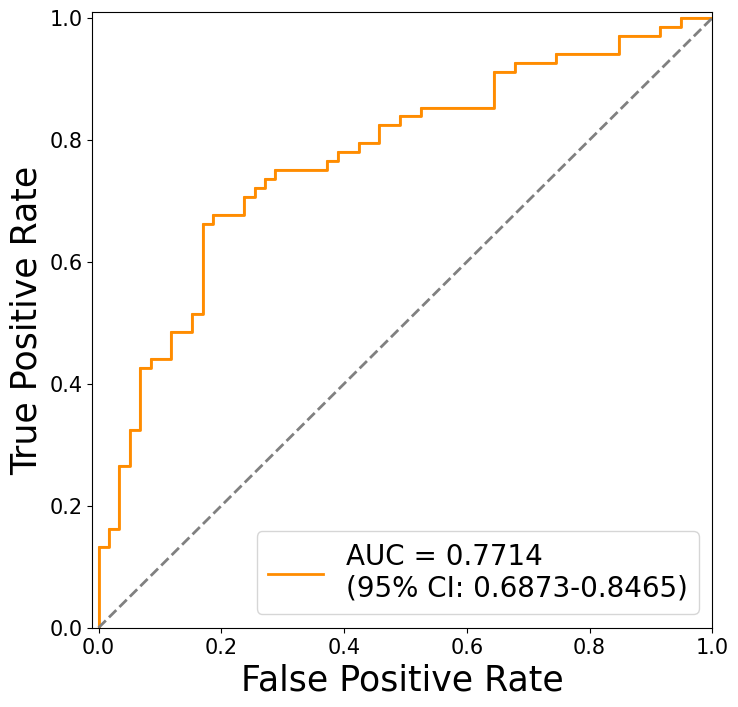

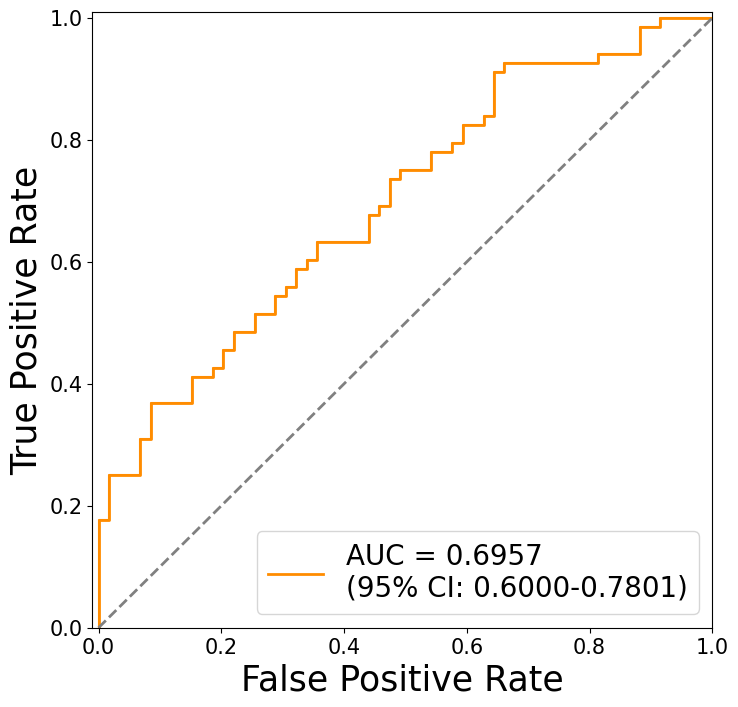

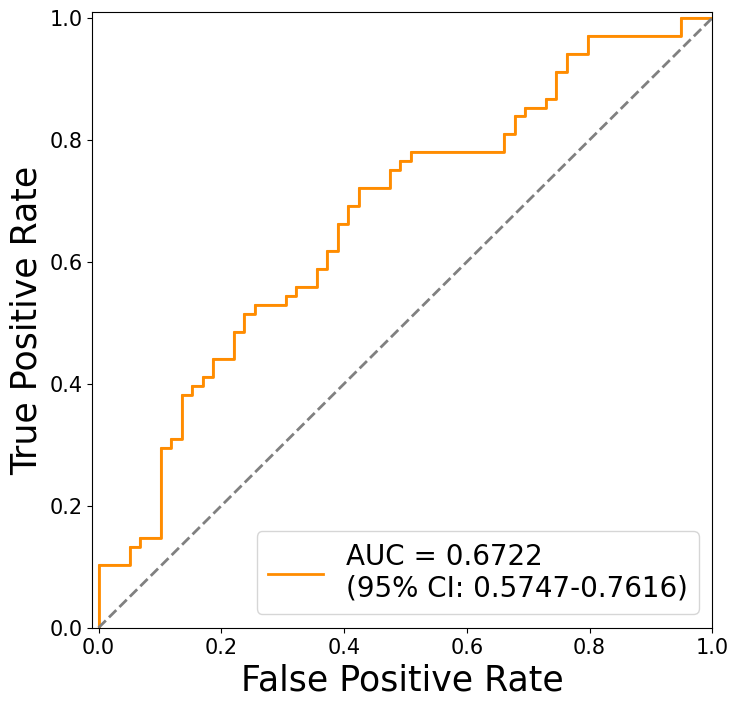

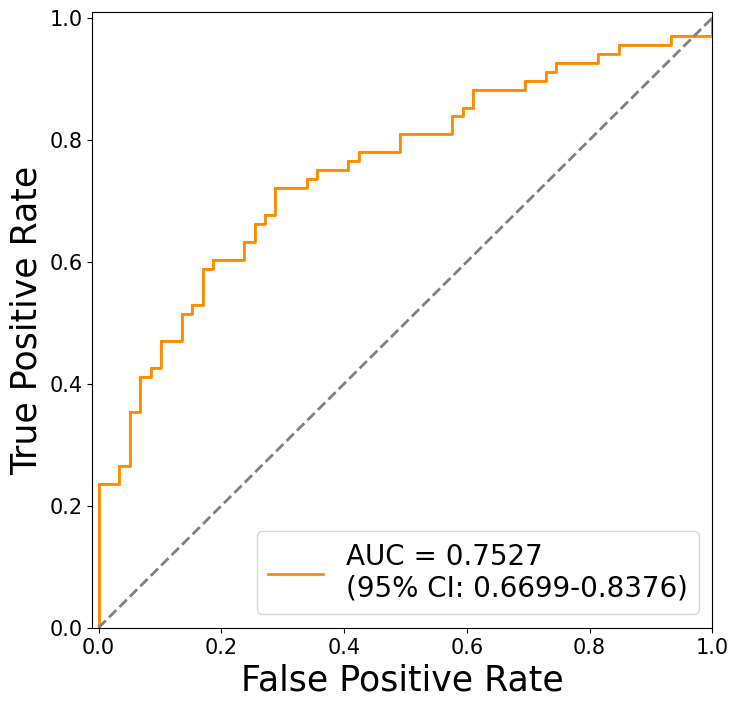

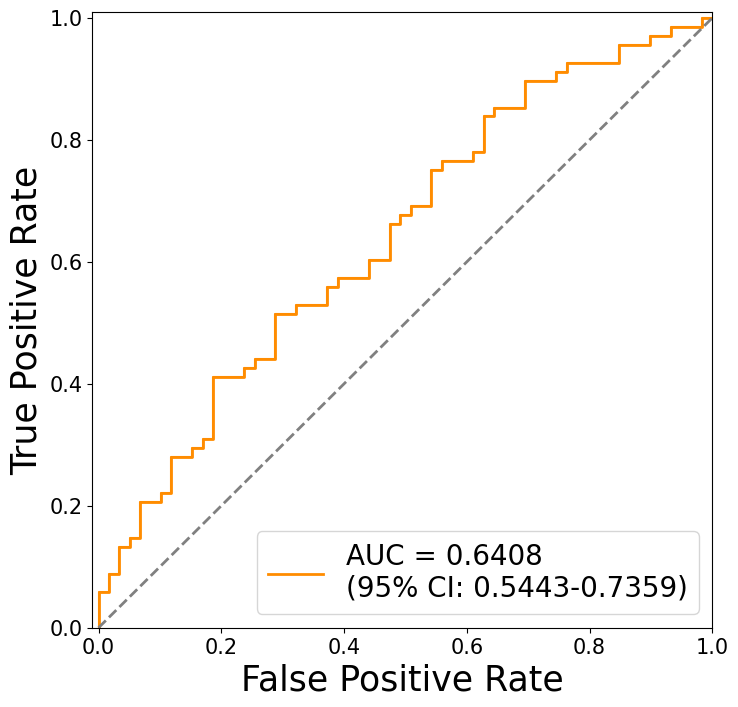

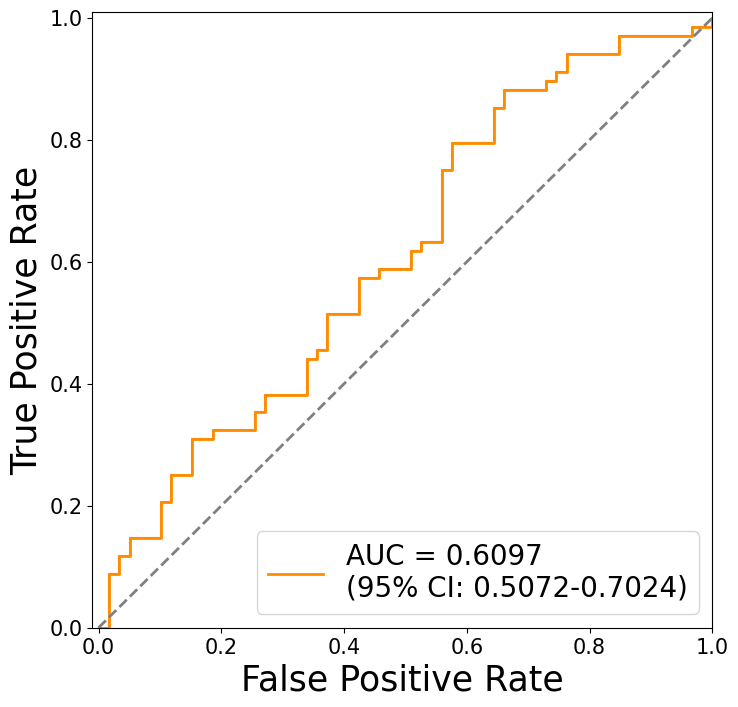

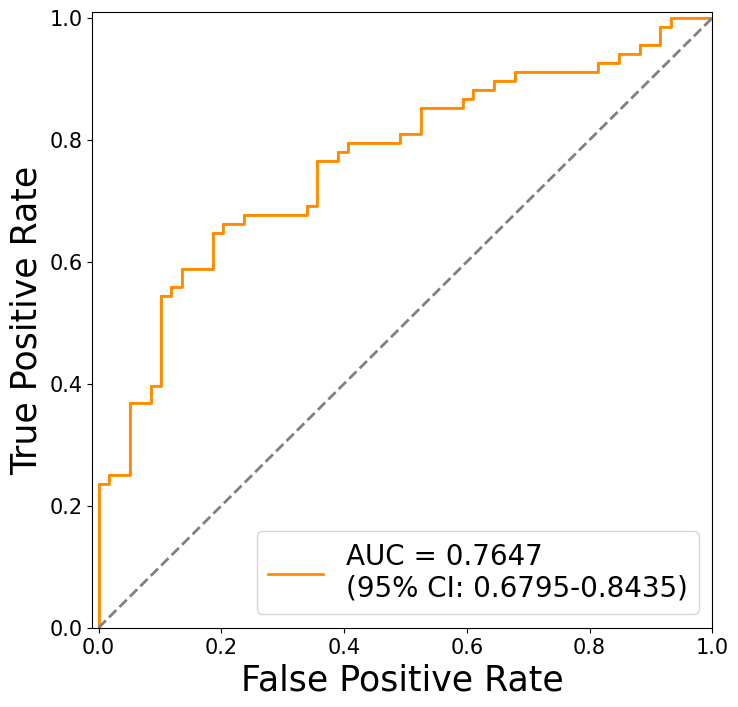

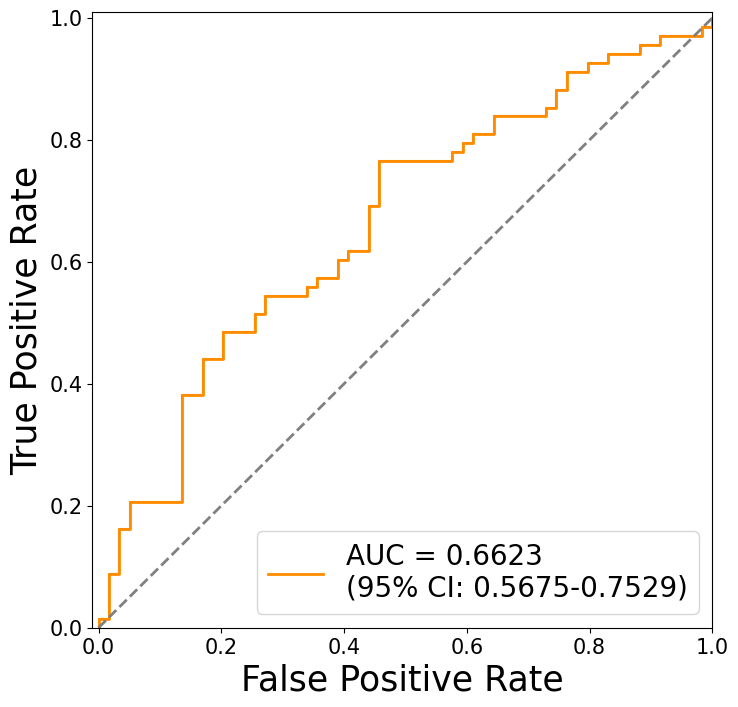

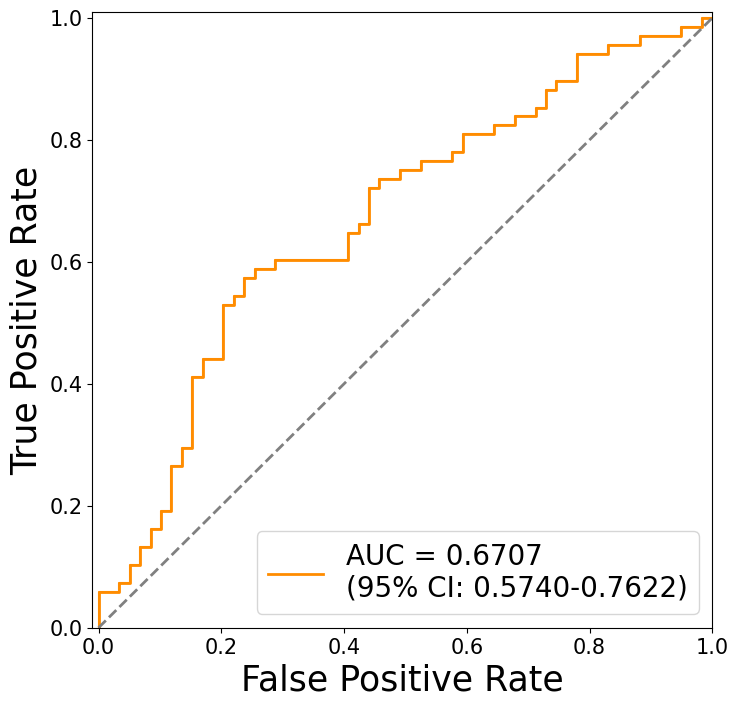

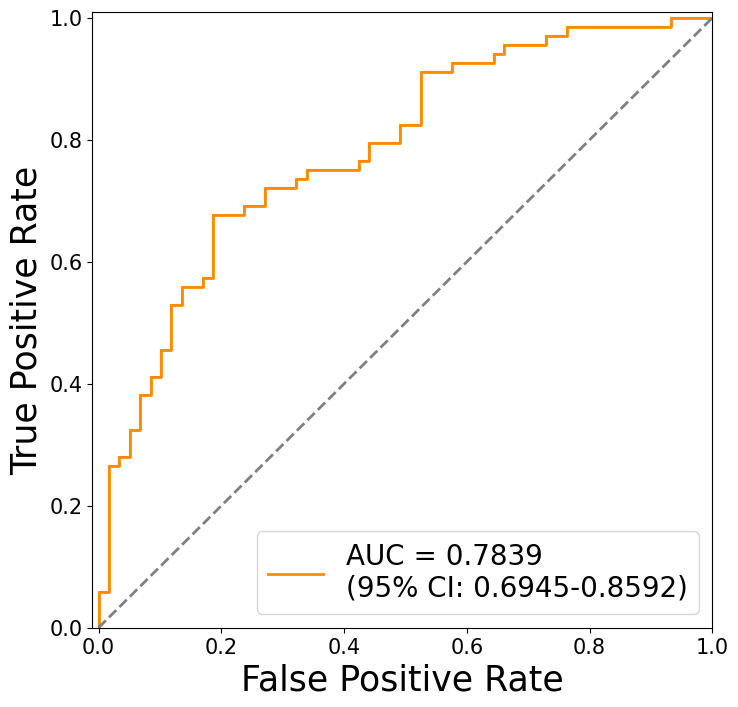

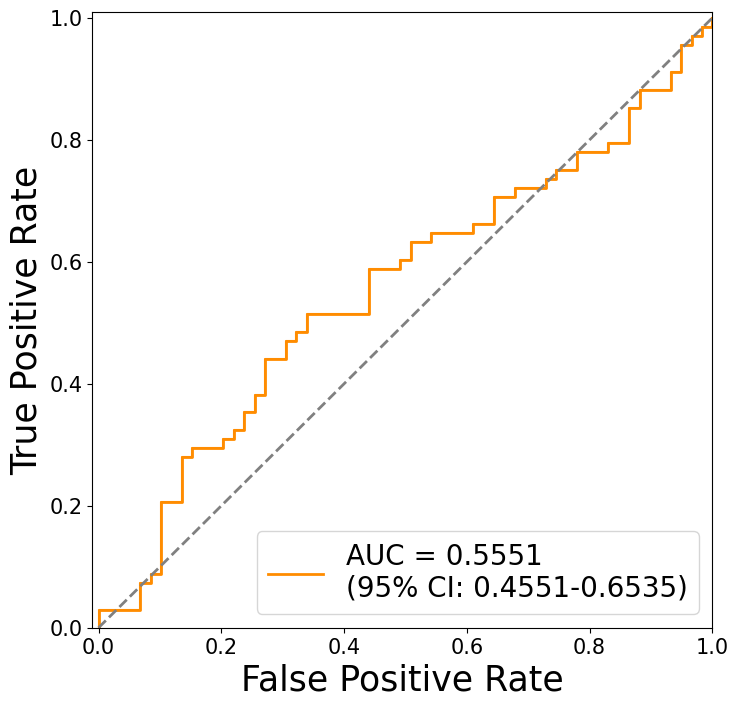

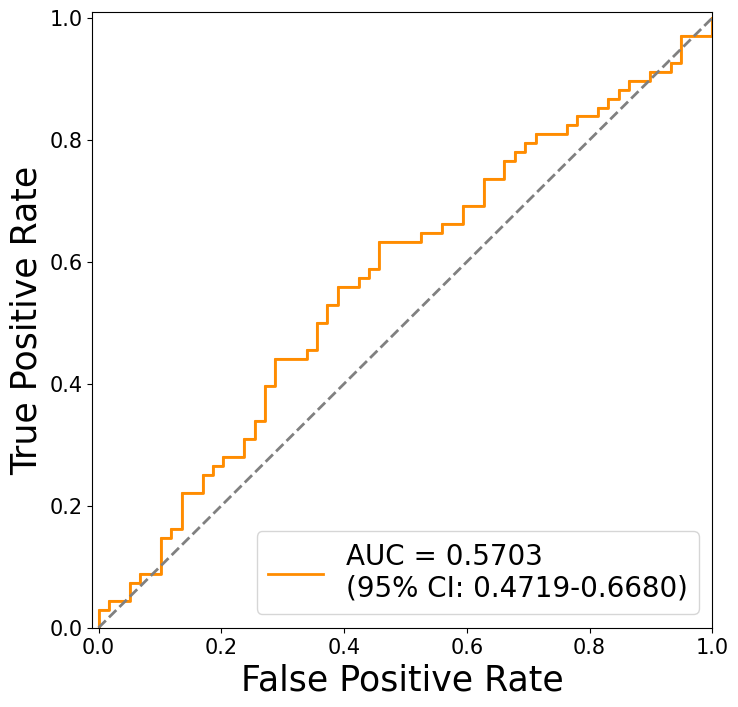

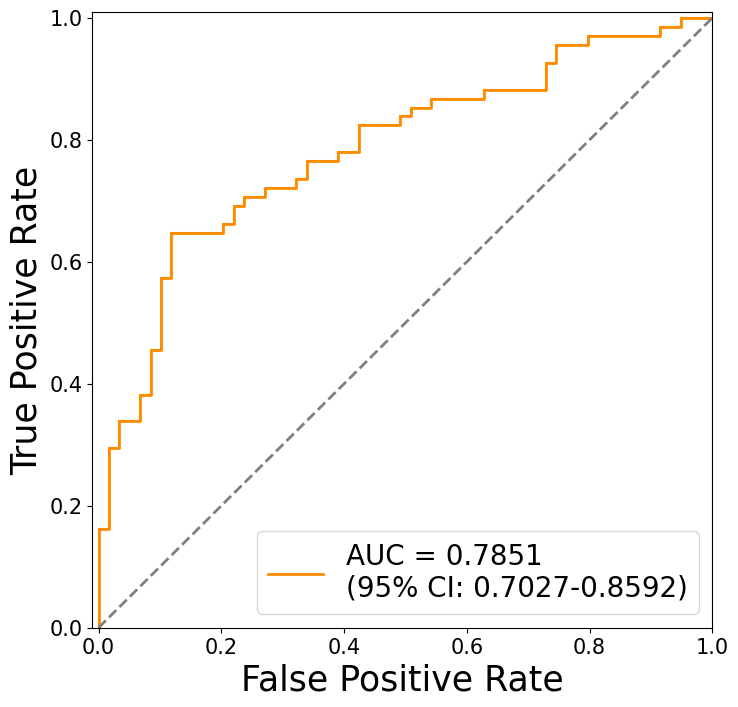

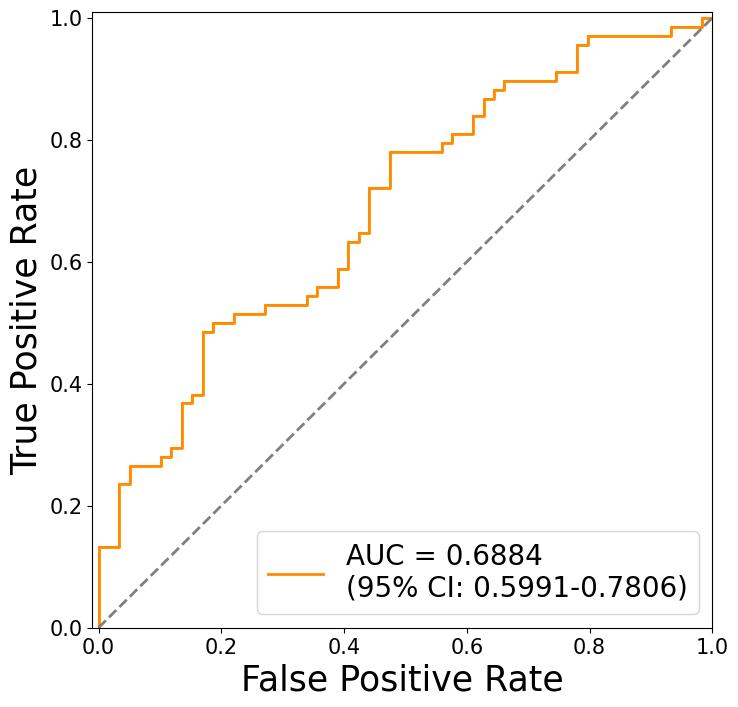

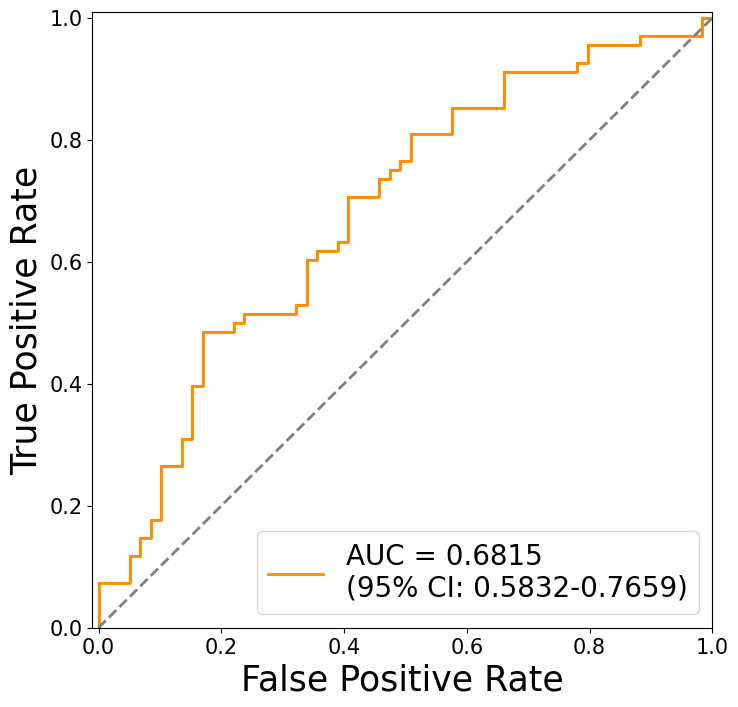

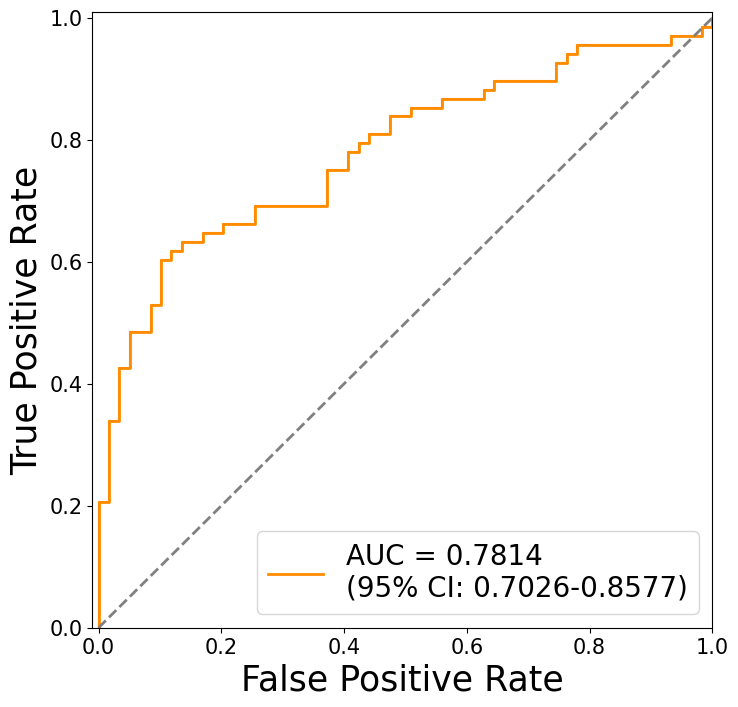

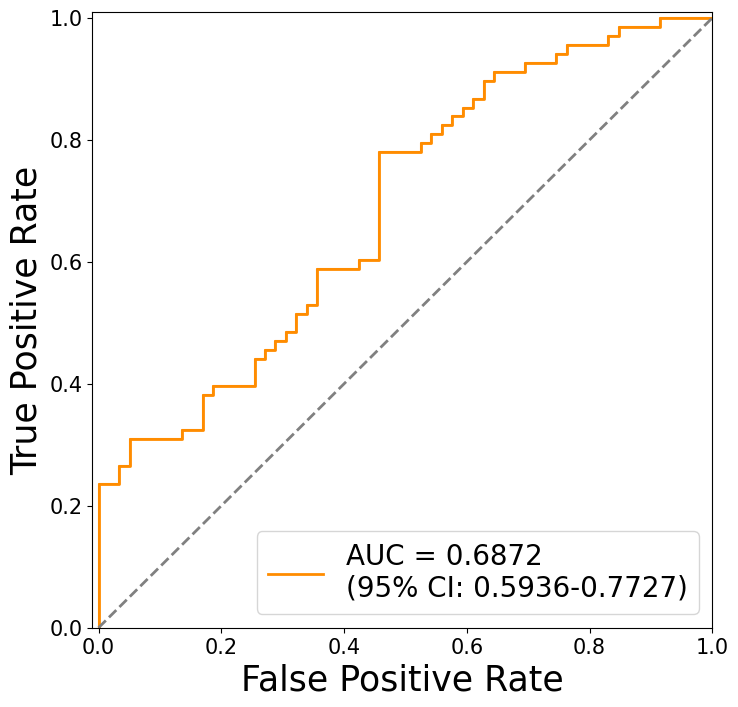

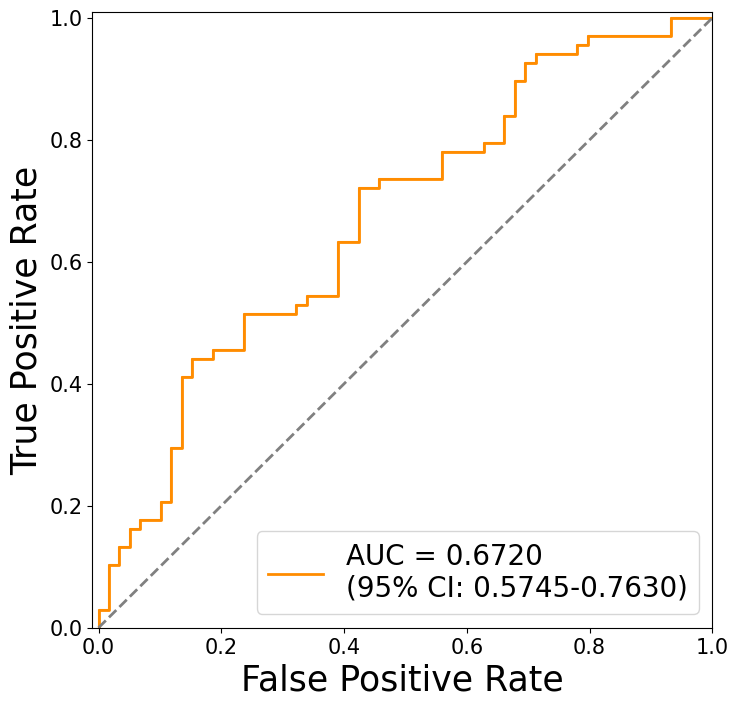

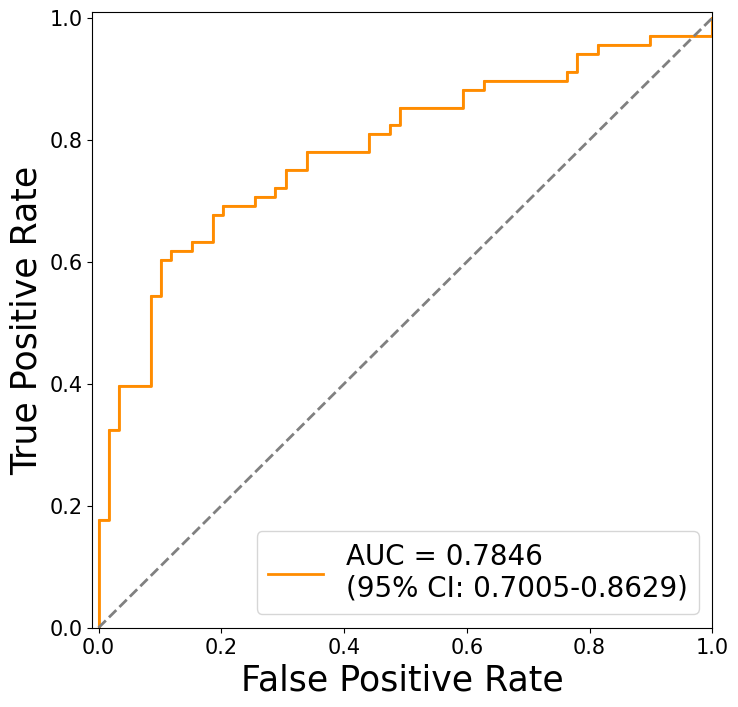

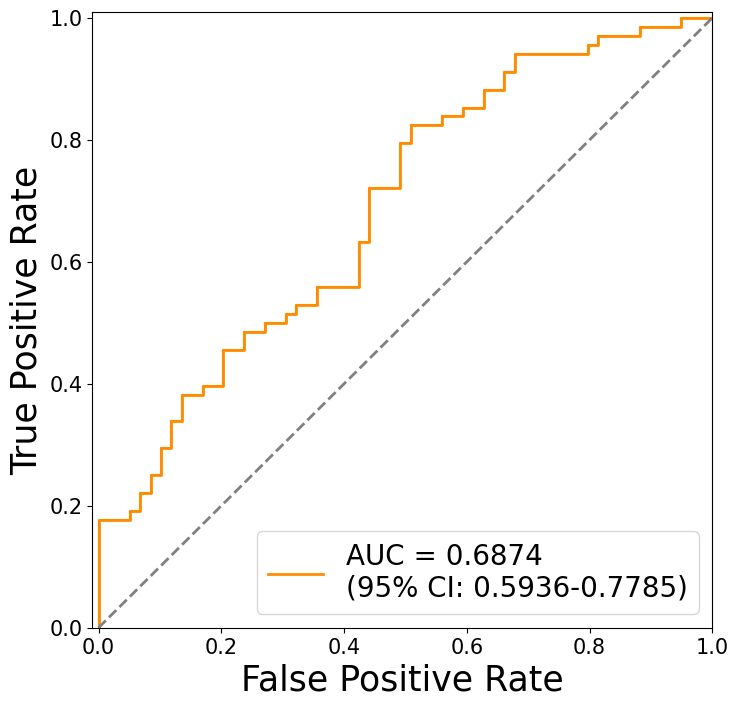

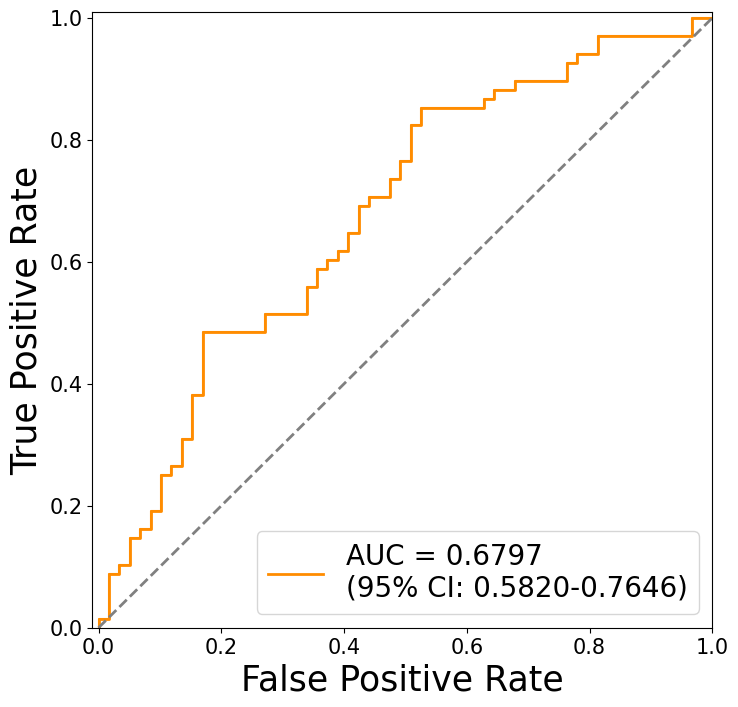

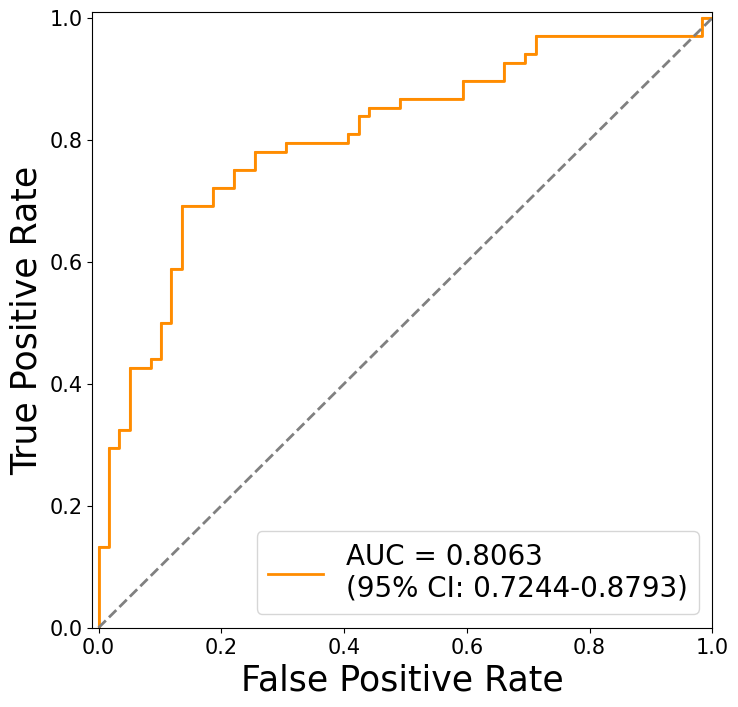

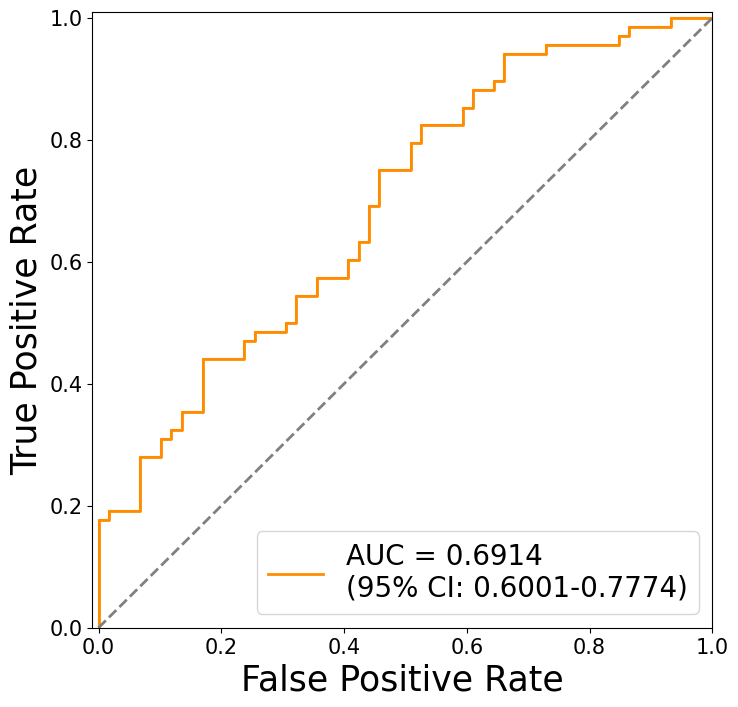

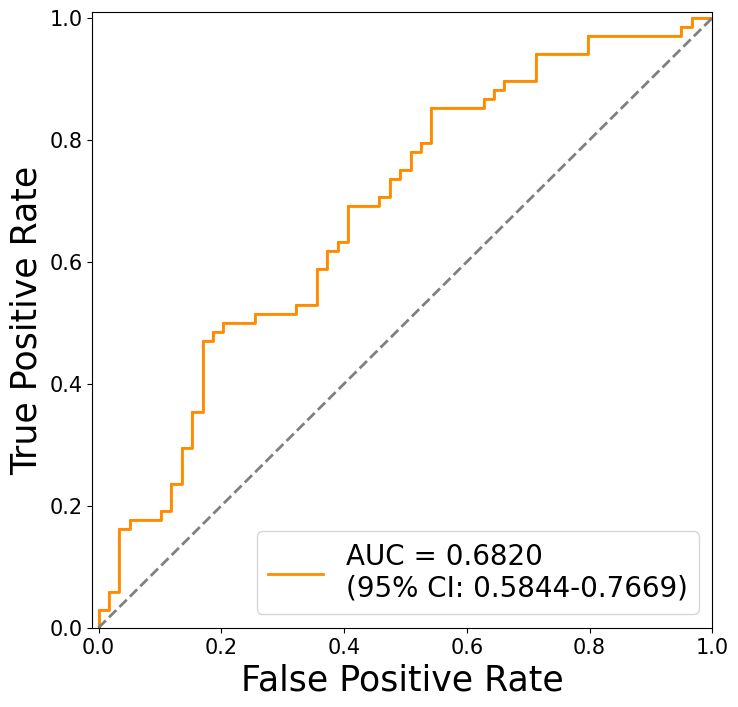

{'vgg16': {'finetuning': 0.64200616, 'fromscratch': 0.20658252, 'freeze': 0.309608}, 'resnet50': {'finetuning': 0.75999725, 'fromscratch': 0.47795603, 'freeze': 0.49028656}, 'vgg19': {'finetuning': 0.45345092, 'fromscratch': 0.57150465, 'freeze': 0.5971167}, 'resnet152': {'finetuning': 0.452556, 'fromscratch': 0.508436, 'freeze': 0.49802727}, 'vgg16+vgg19': {'finetuning': 0.5735399, 'fromscratch': 0.42025214, 'freeze': 0.31103748}, 'vgg16+resnet50': {'finetuning': 0.7608454, 'fromscratch': 0.38899285, 'freeze': 0.40663135}, 'vgg16+resnet50+vgg19': {'finetuning': 0.6899367, 'fromscratch': 0.42975545, 'freeze': 0.3663938}, 'vgg16+resnet50+vgg19+resnet152': {'finetuning': 0.5881201, 'fromscratch': 0.44653523, 'freeze': 0.3973596}}


In [13]:
def get_filtered_result(proba, label, age):
    temp_proba, temp_label,temp_age = [], [], []
    for i in range(len(age)):
        targeted = False
        if group == 'AGE1'   and (age[i] <= 50): targeted = True
        if group == 'AGE2'   and (age[i] > 50): targeted = True
        if targeted == True:
            temp_proba.append(proba[i])
            temp_label.append(label[i])
            temp_age.append(age[i])
    proba = np.array(temp_proba)
    label = np.array(temp_label)
    age = np.array(temp_age)
    return proba, label, age

val_threshold = {}
for model_name in ['vgg16','resnet50', 'vgg19', 'resnet152', 'vgg16+vgg19','vgg16+resnet50', 'vgg16+resnet50+vgg19', 'vgg16+resnet50+vgg19+resnet152']:
    val_threshold[model_name] = {}
    for train_strategy in train_strategies:
        label =  output[model_name][train_strategy]['val']['label']
        proba =  output[model_name][train_strategy]['val']['proba']

        # Get Threshold...
        auroc, threshold, accuracy = plot_roc_curve(label, proba, '', size=(8,8), save = False, save_path = '')
        val_threshold[model_name][train_strategy] = threshold
    
print(val_threshold)

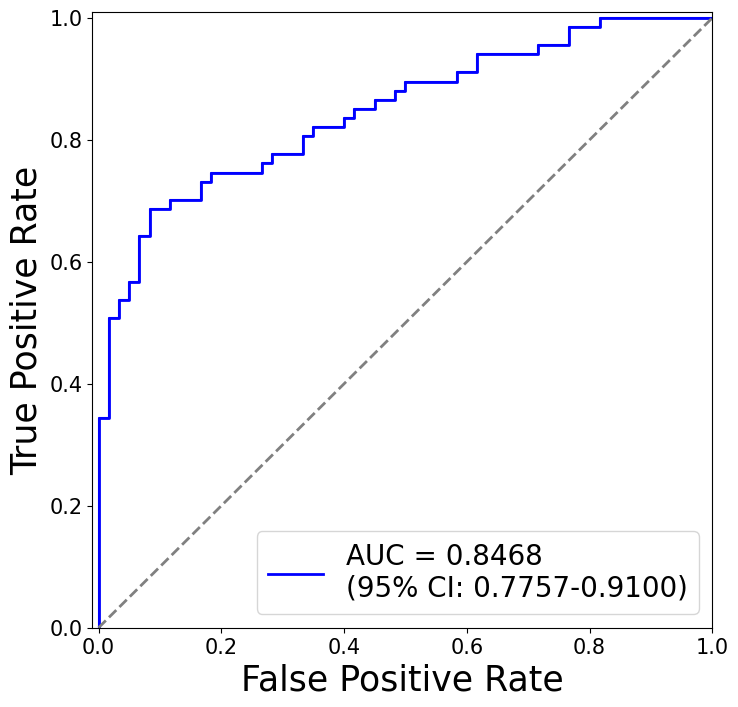

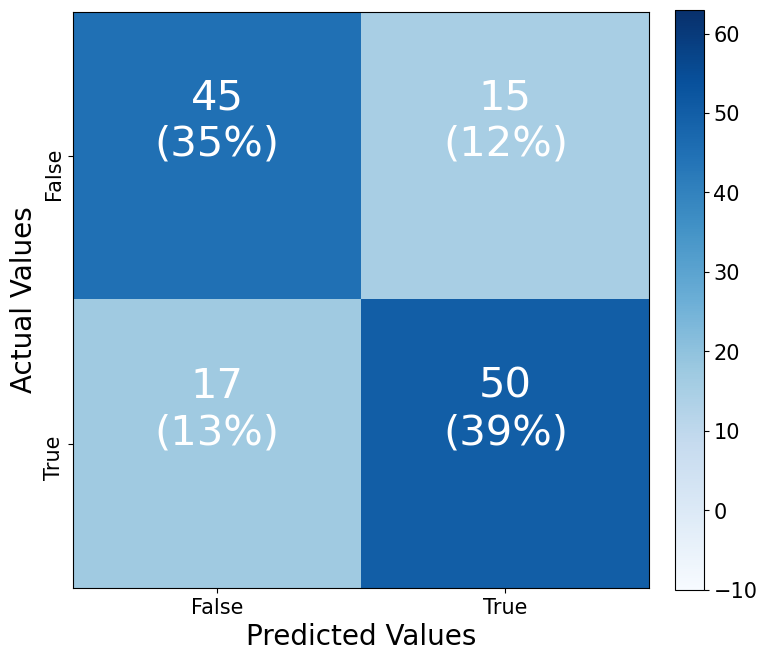

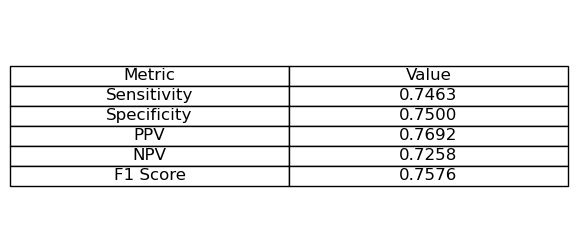

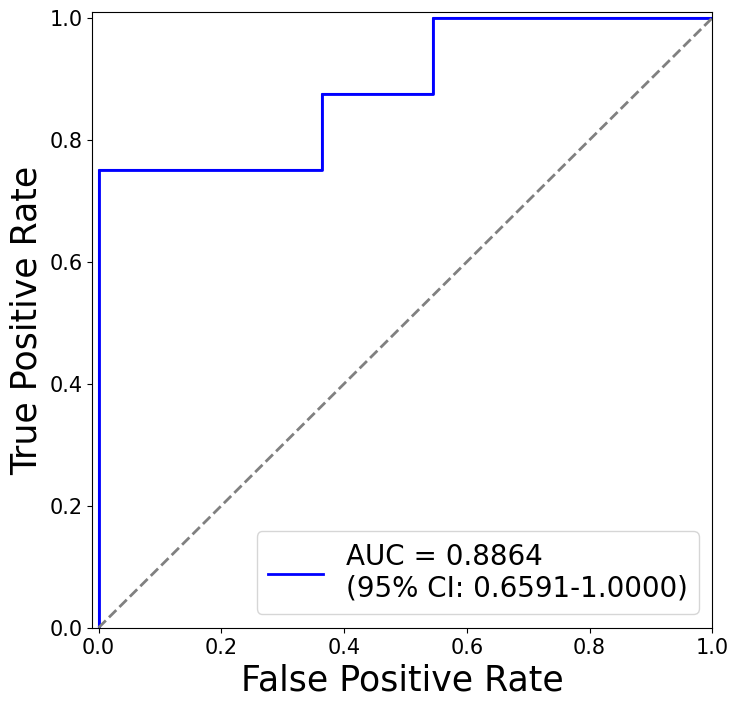

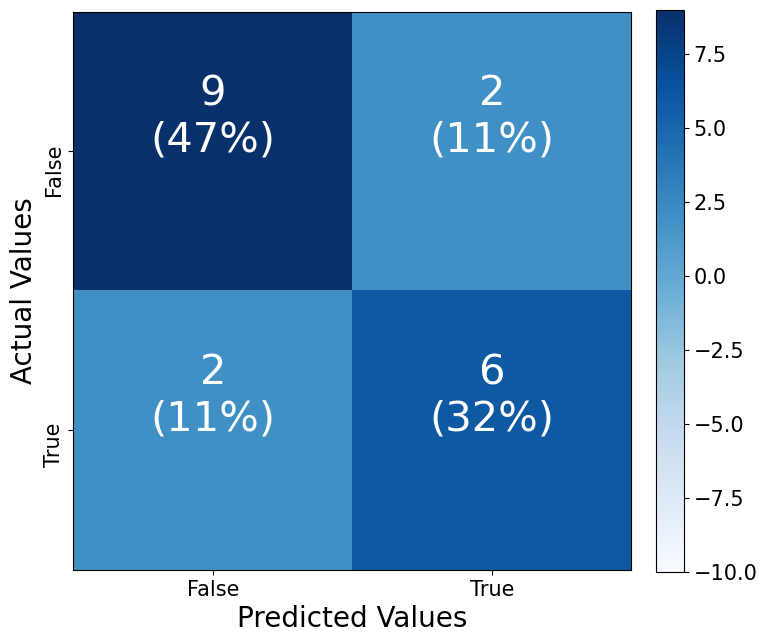

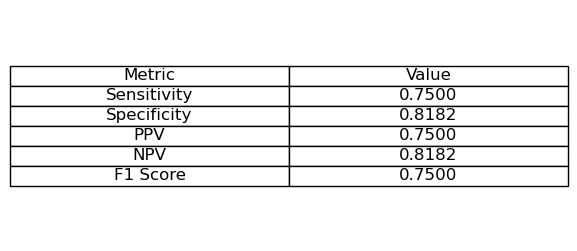

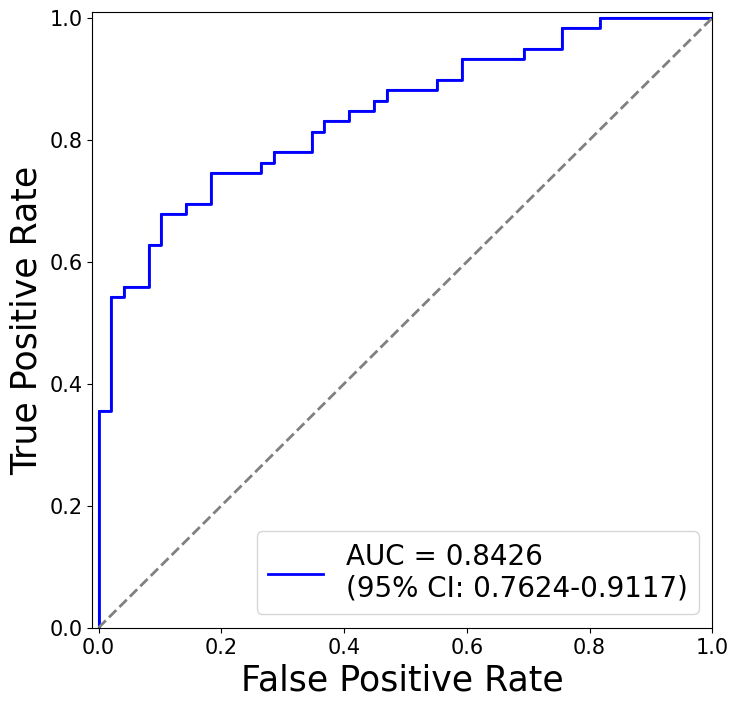

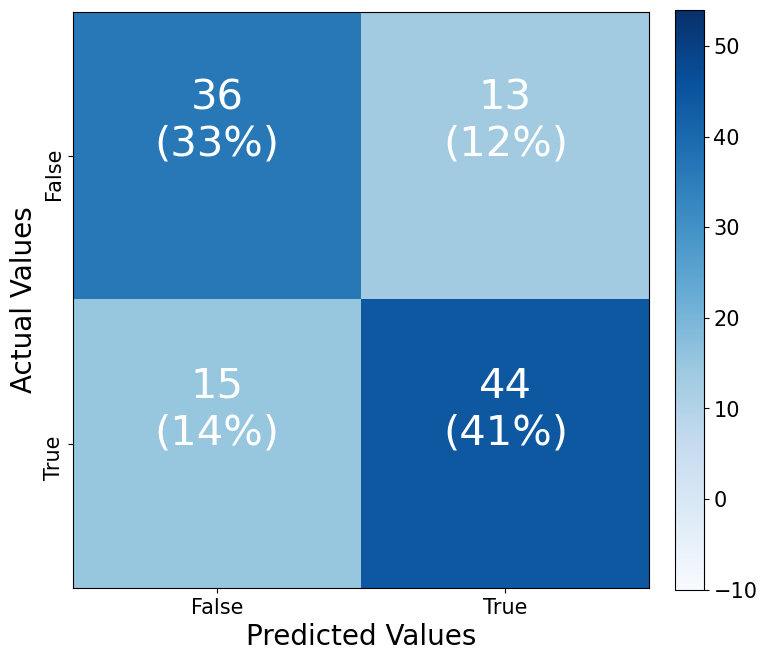

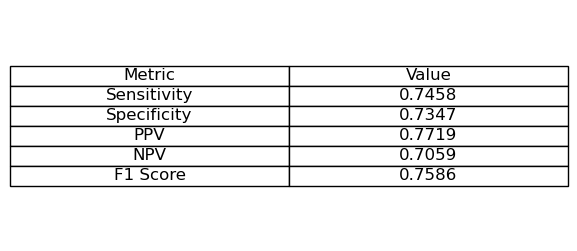

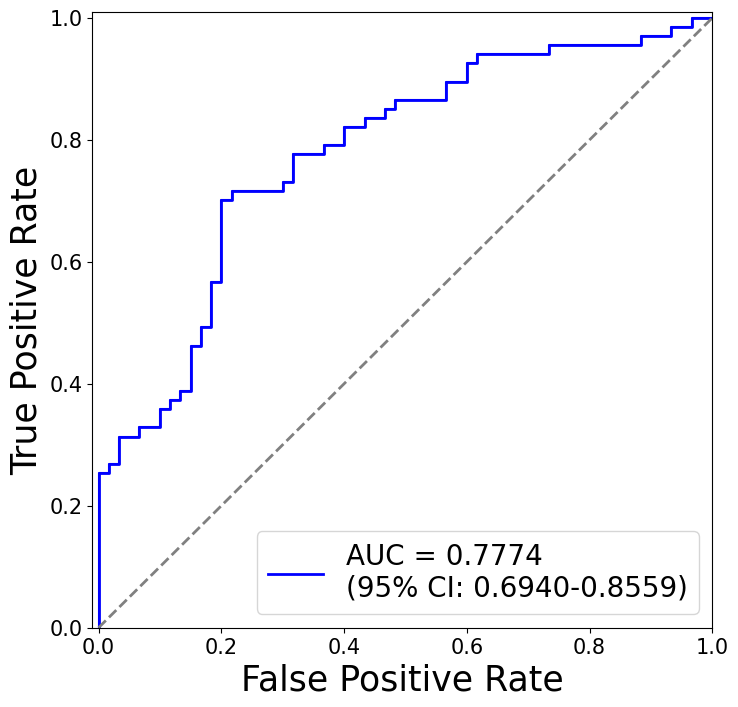

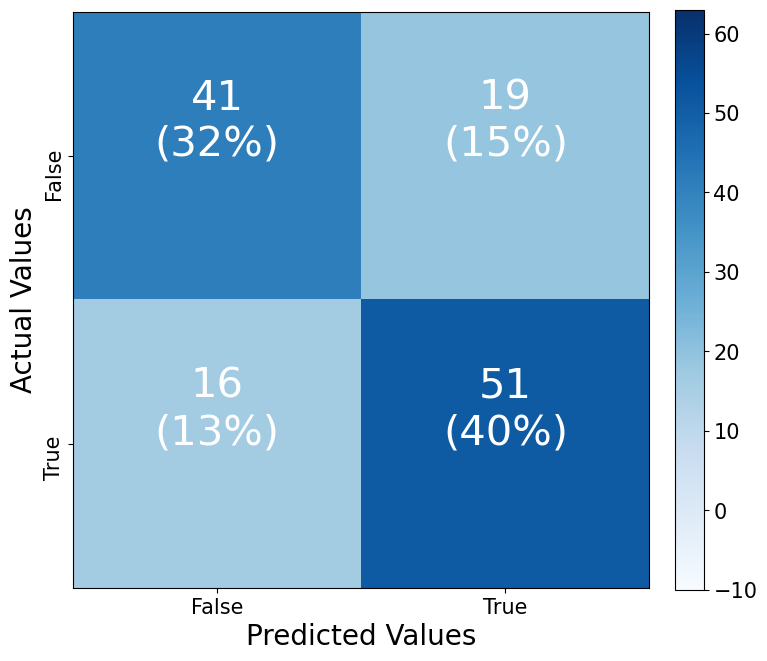

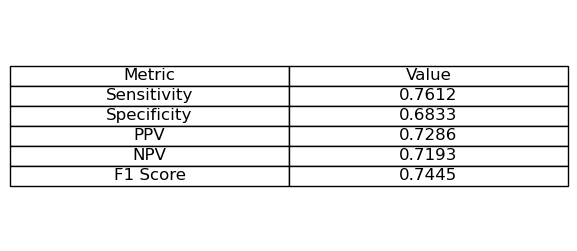

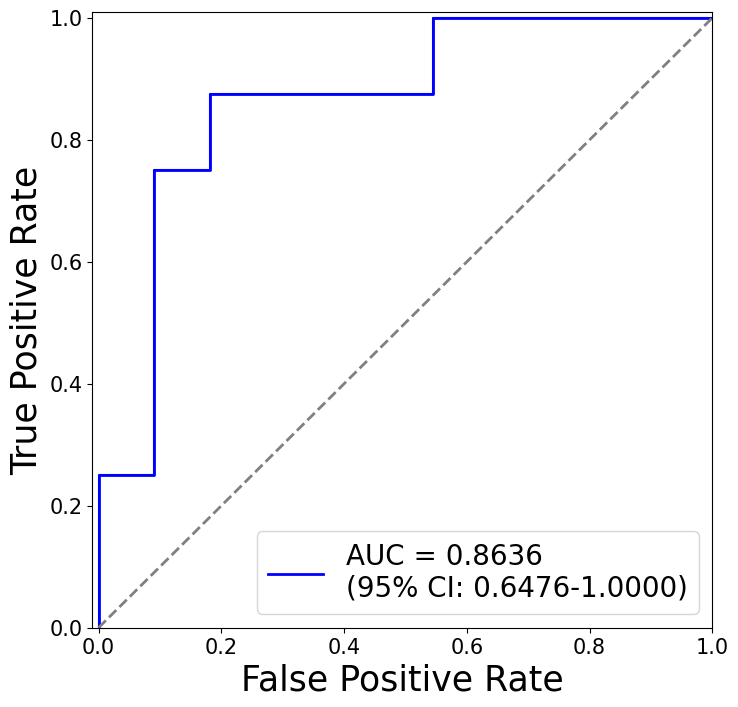

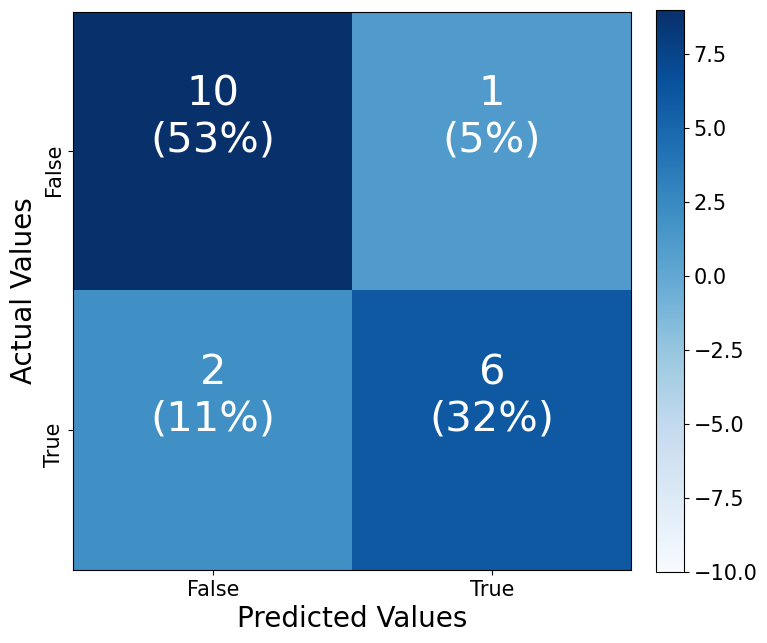

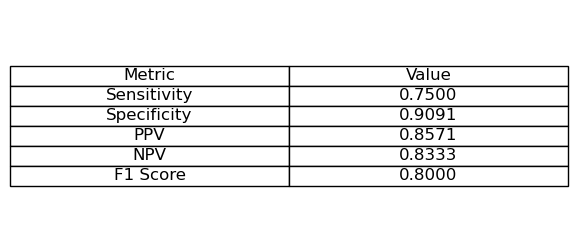

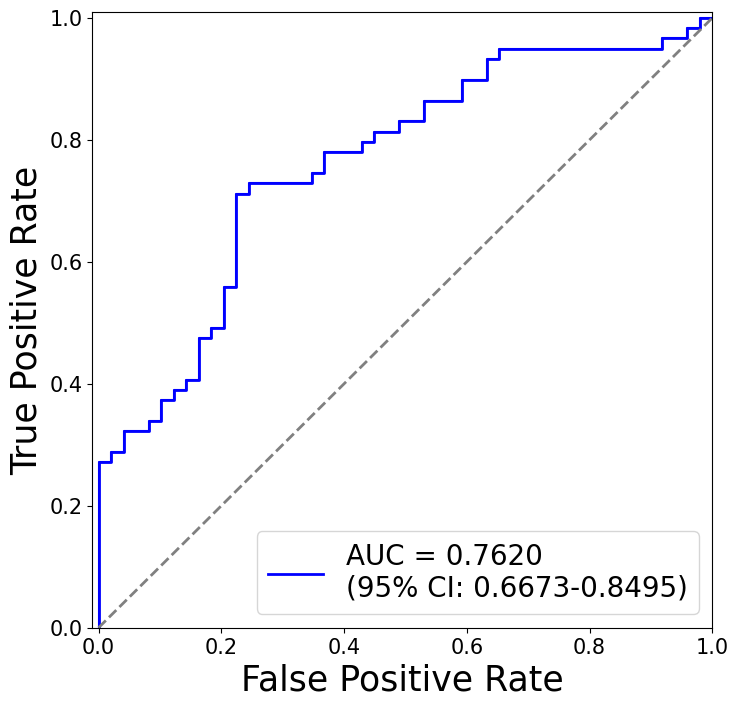

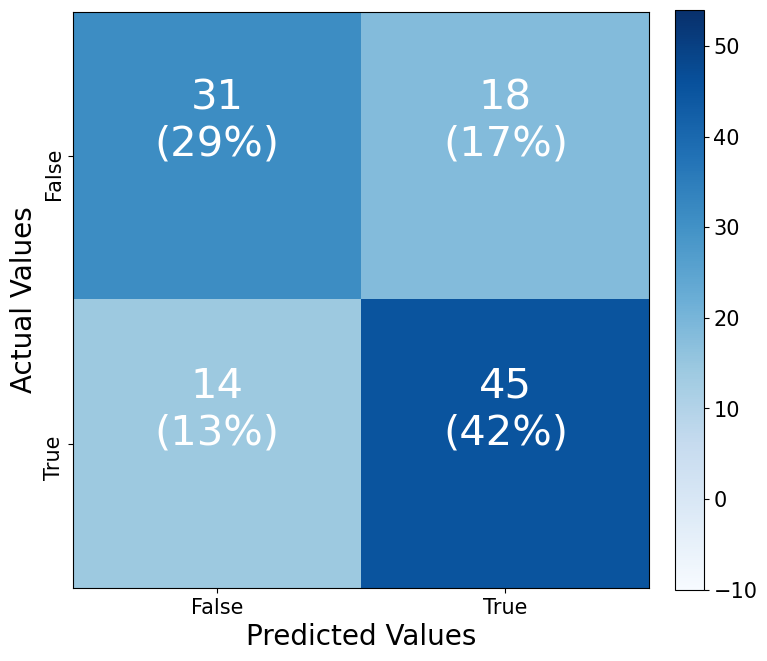

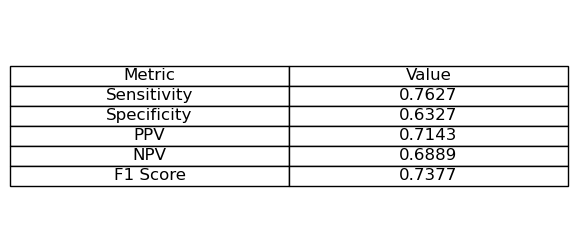

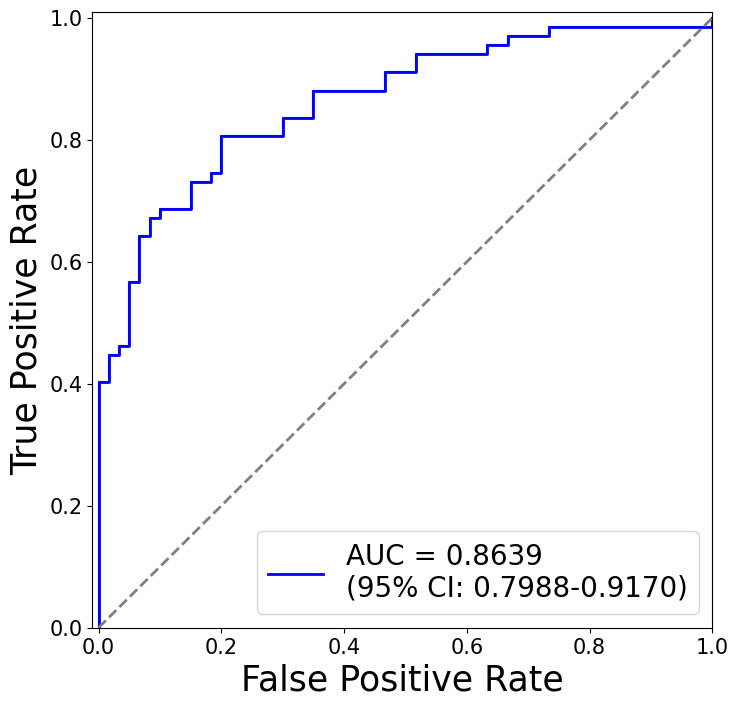

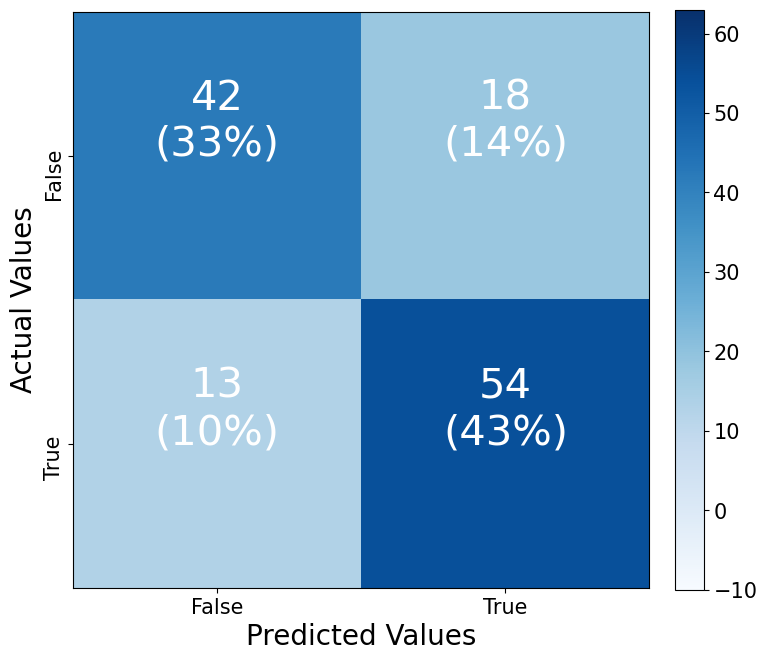

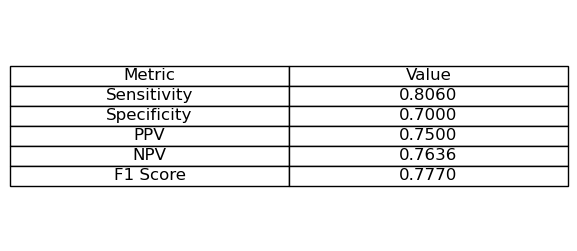

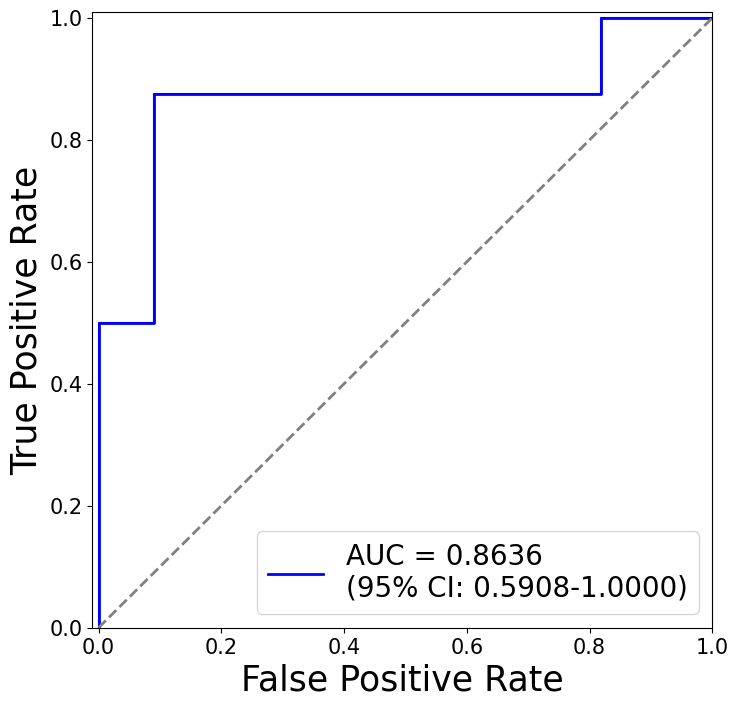

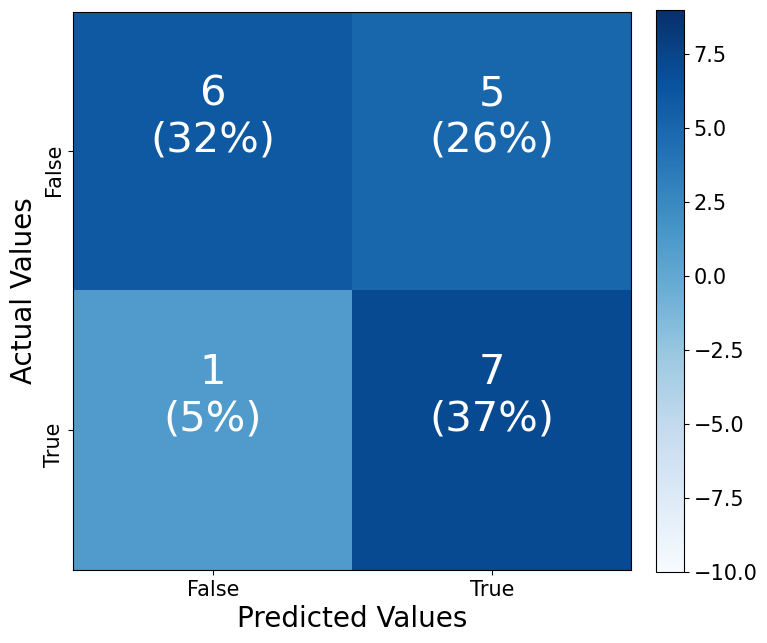

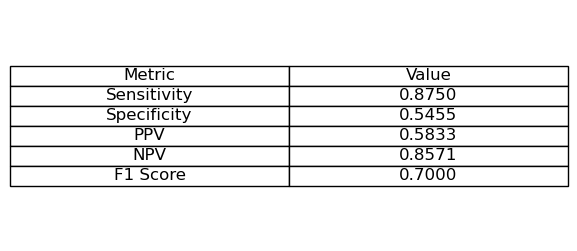

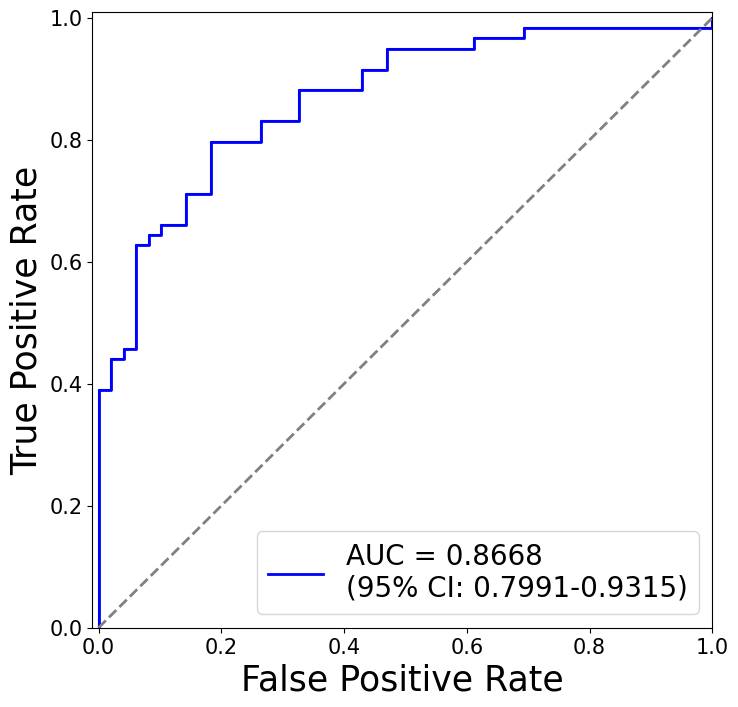

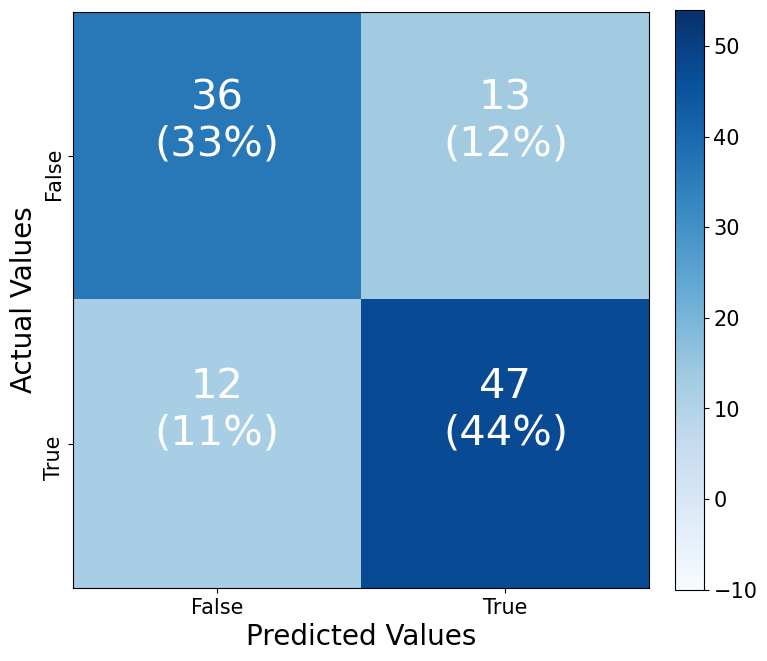

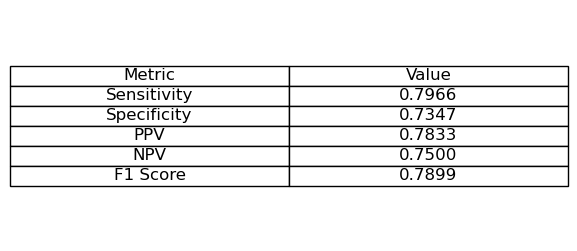

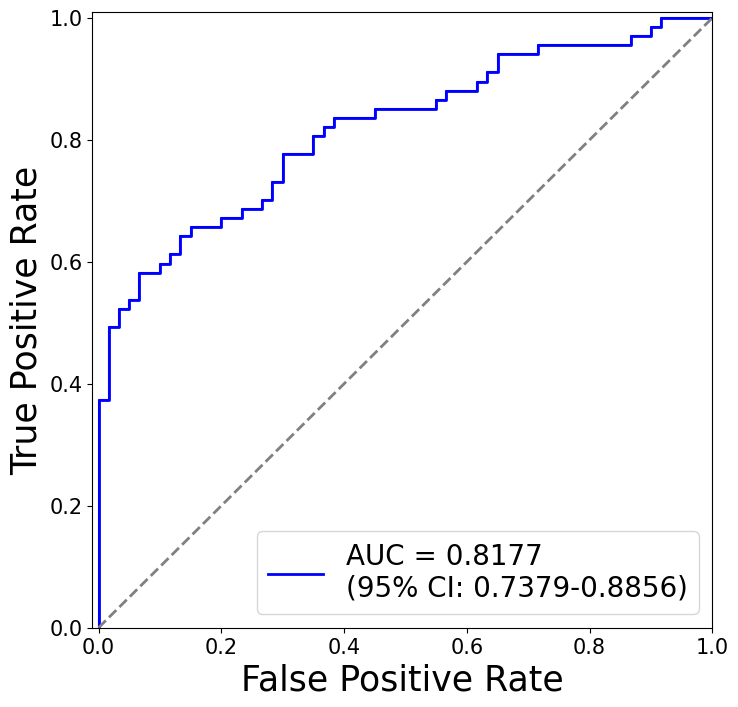

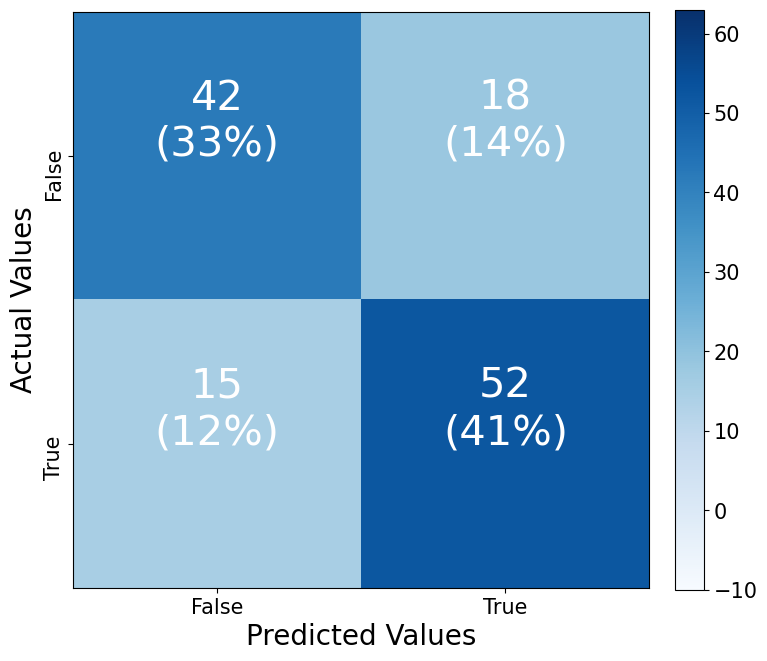

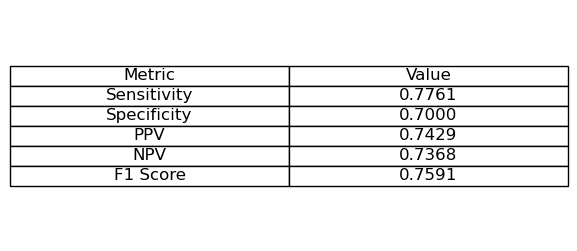

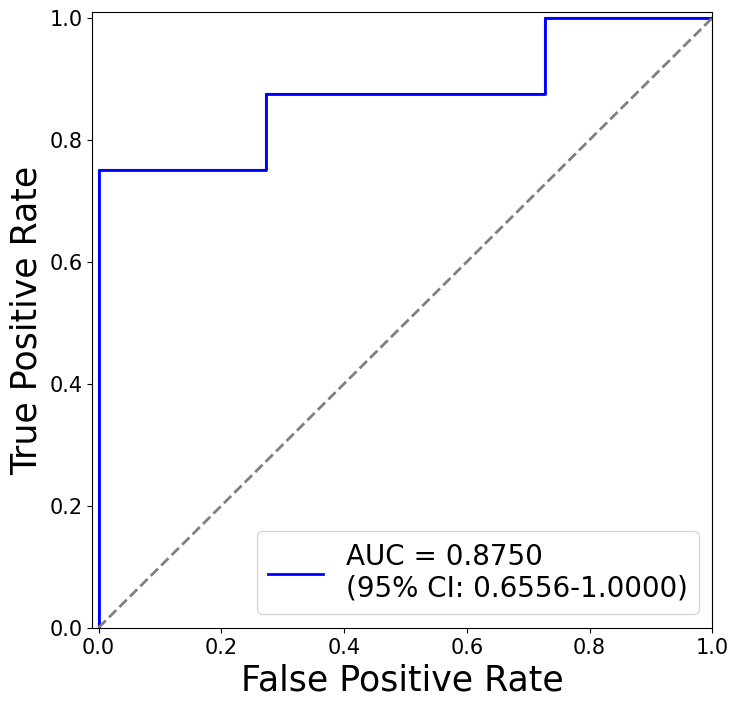

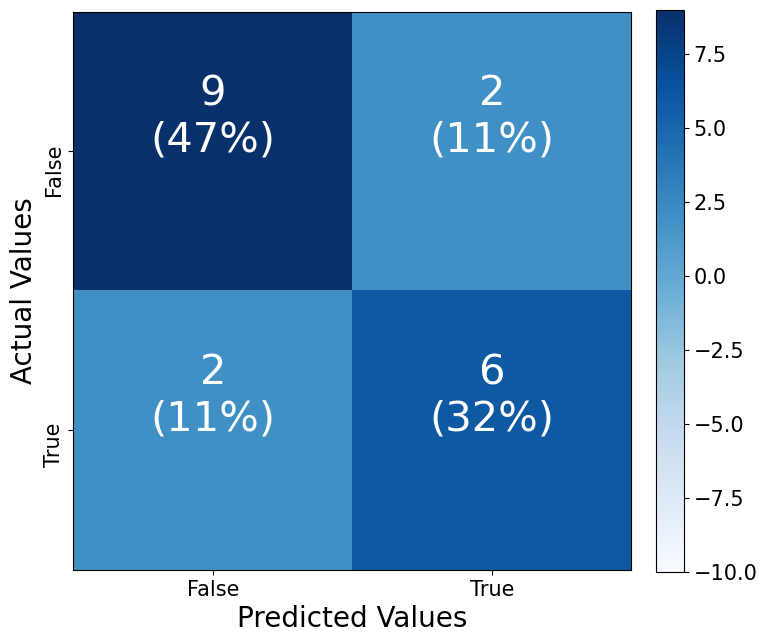

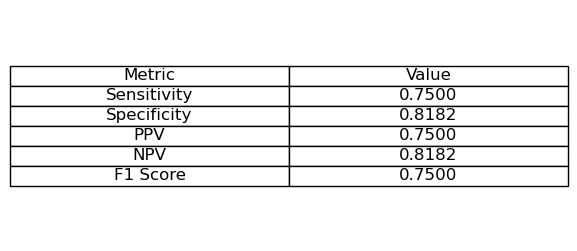

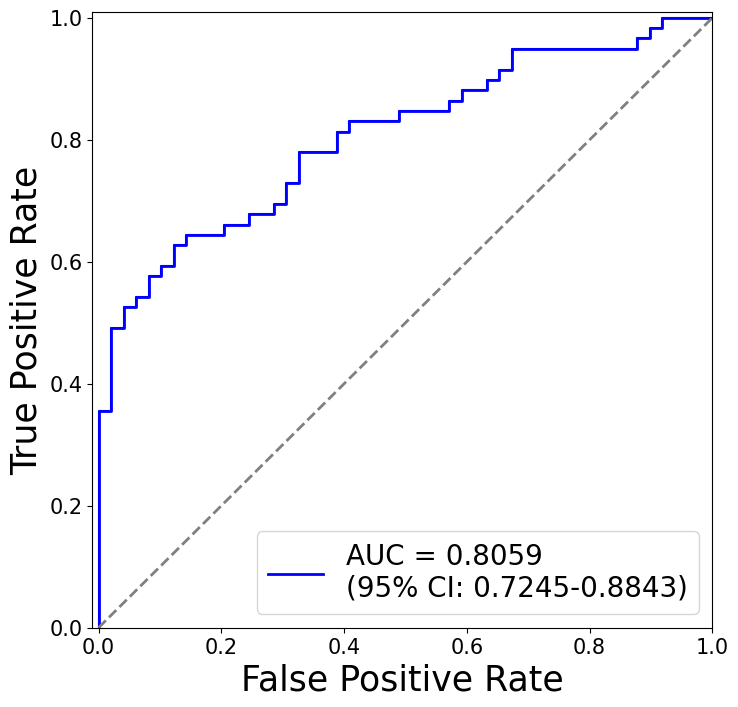

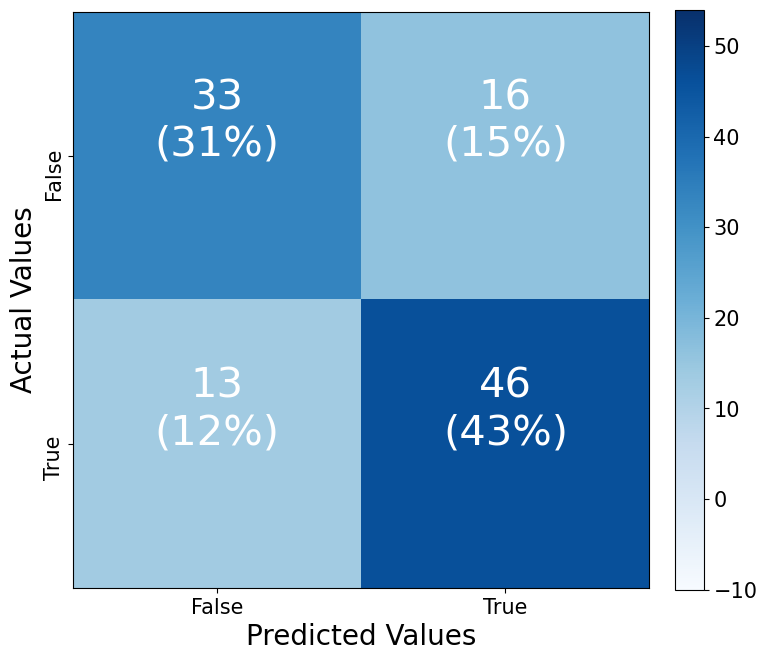

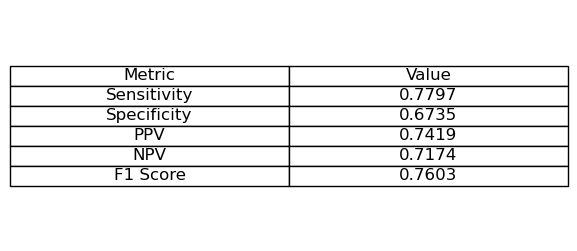

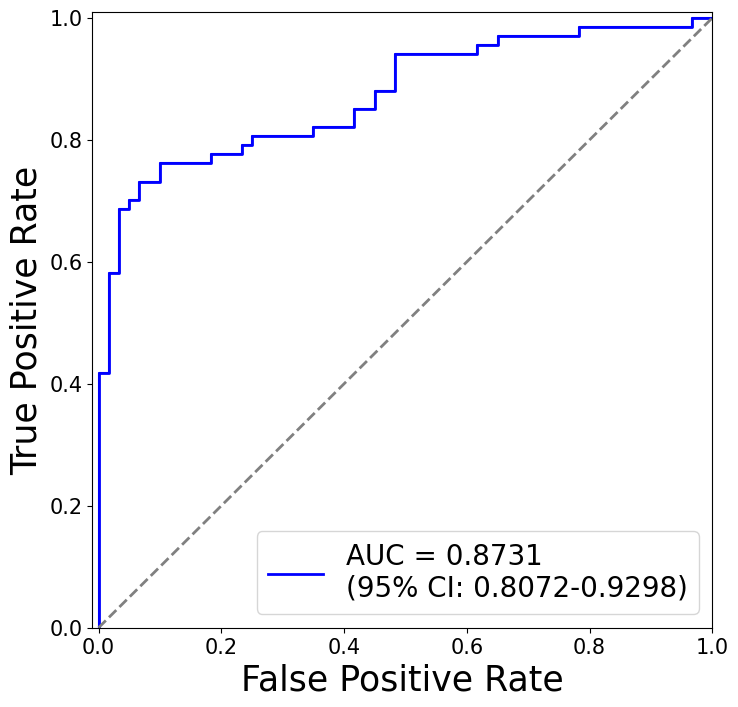

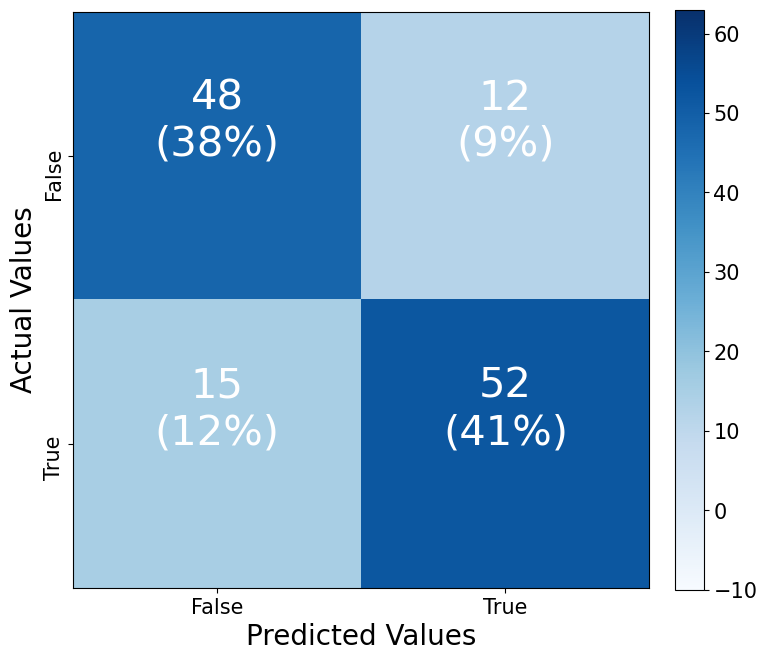

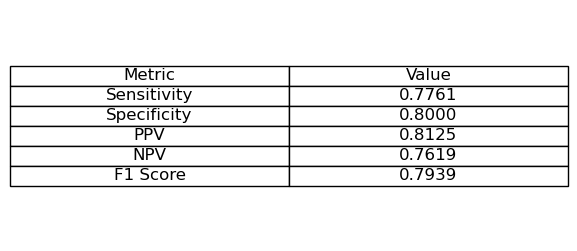

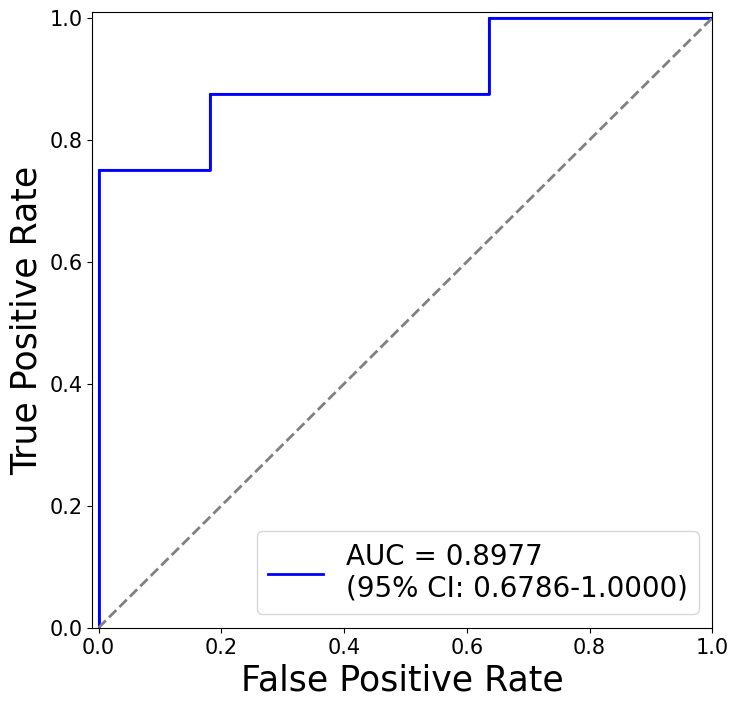

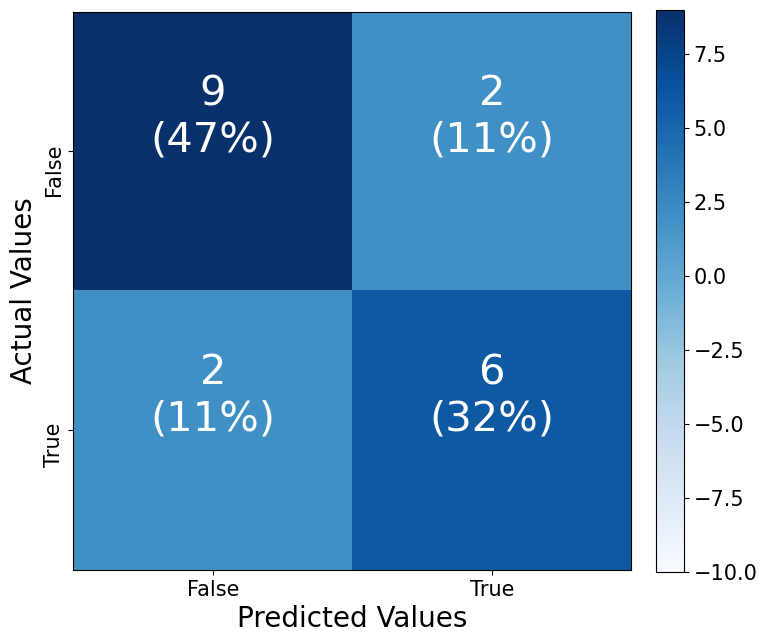

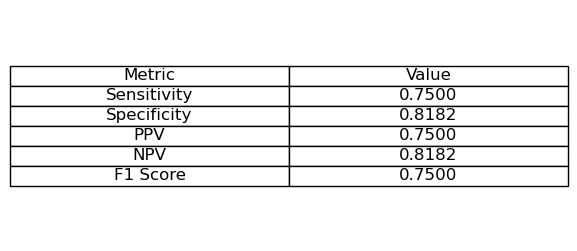

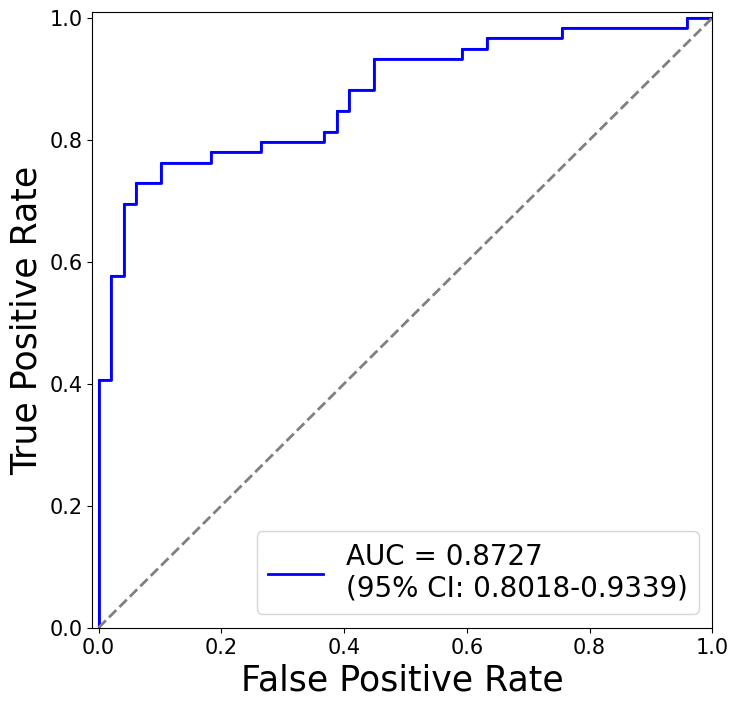

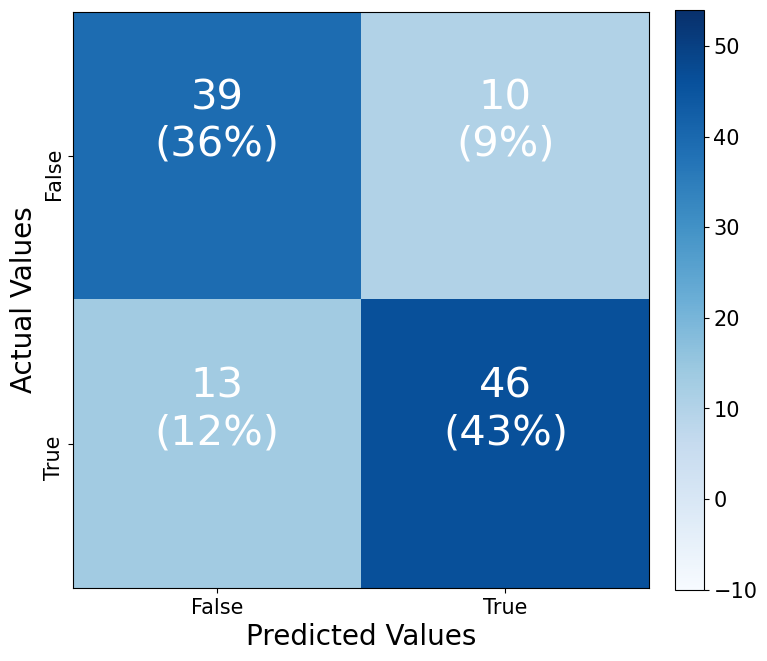

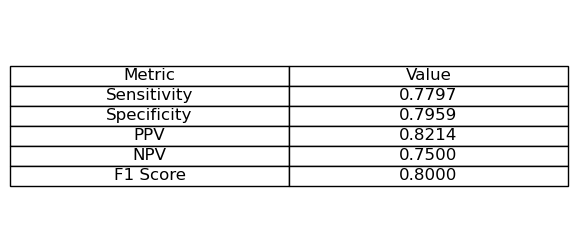

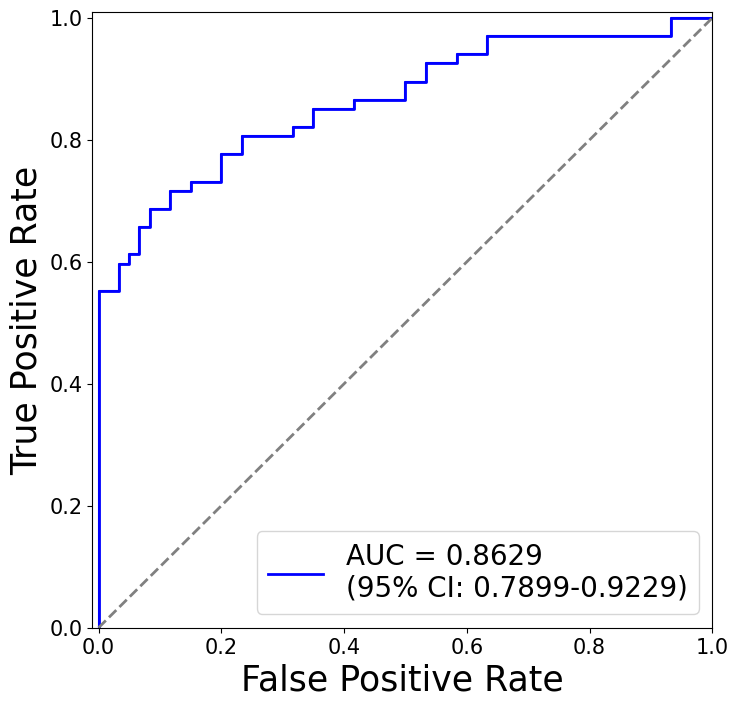

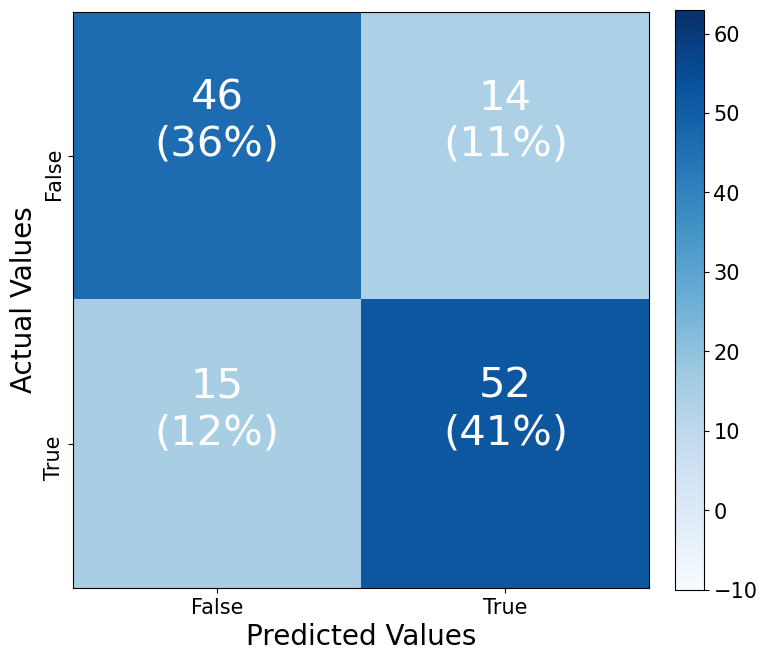

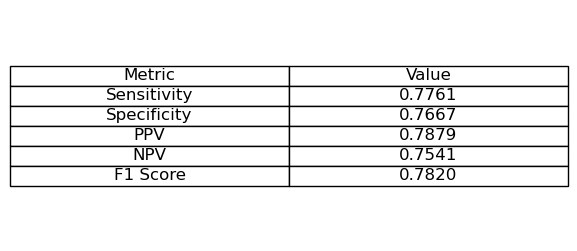

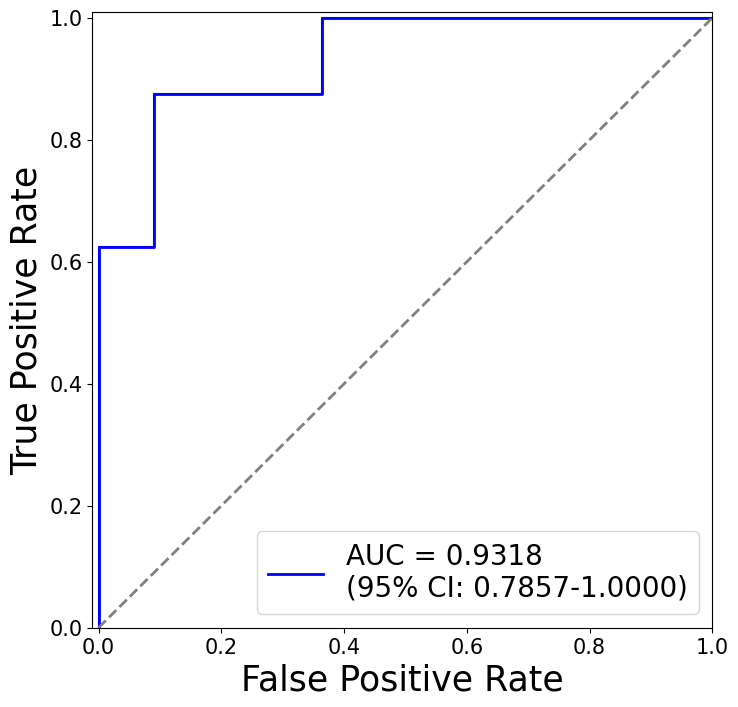

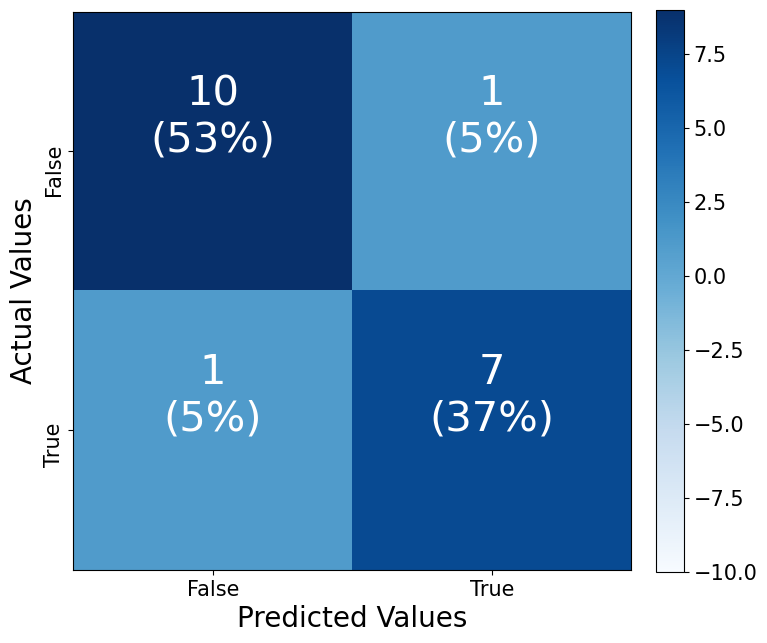

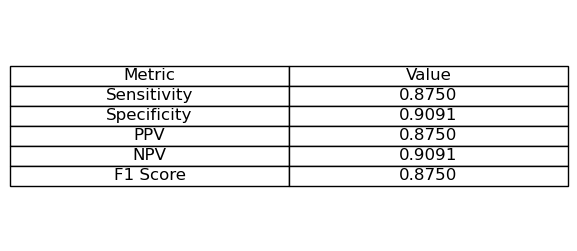

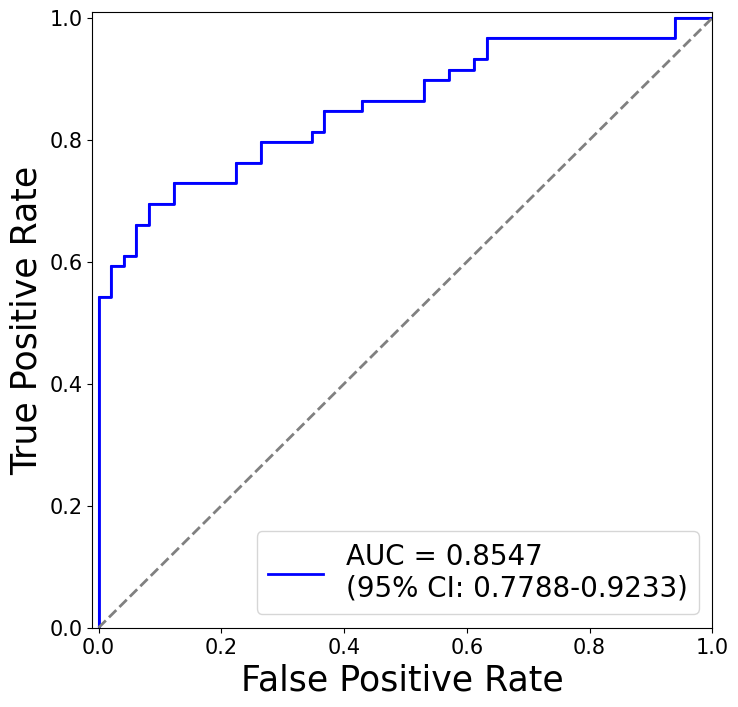

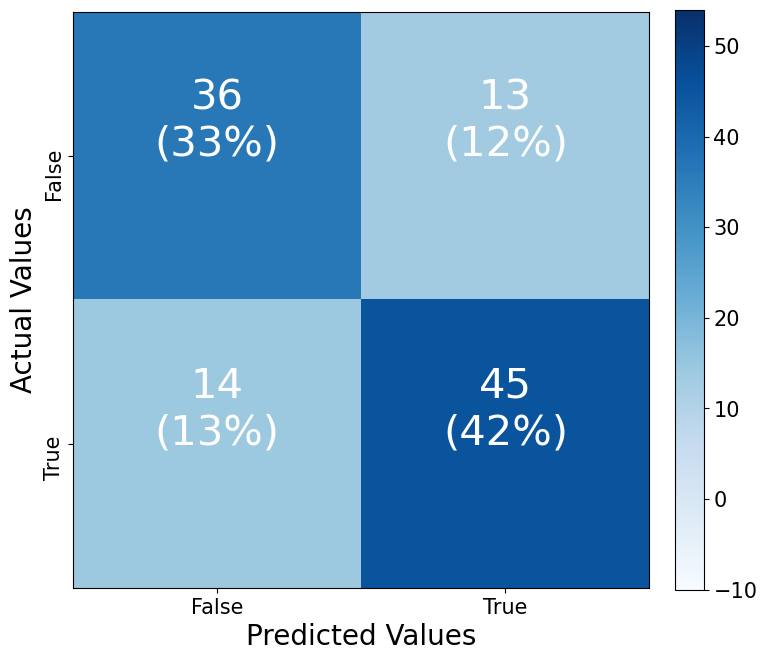

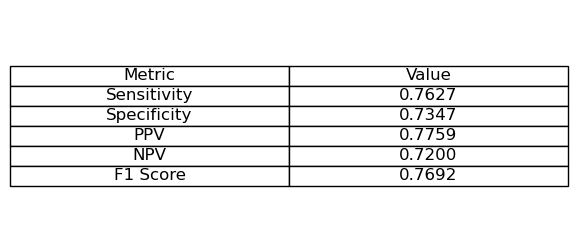

In [16]:
# Calculate additional metrics
def calculate_metrics(conf_matrix):
    TN, FP, FN, TP = conf_matrix.ravel()
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    PPV = TP / (TP + FP) if (TP + FP) > 0 else 0
    NPV = TN / (TN + FN) if (TN + FN) > 0 else 0
    # Calculate F1 Score
    F1 = 2 * (PPV * sensitivity) / (PPV + sensitivity) if (PPV + sensitivity) > 0 else 0
    return sensitivity, specificity, PPV, NPV, F1

# Create table plot for metrics
def plot_metrics_table(metrics, group, save_path=None):
    fig, ax = plt.subplots(figsize=(6, 3))  # Adjust height for additional row
    ax.axis('off')  # Turn off the axis

    # Table content
    table_data = [
        ["Metric", "Value"],
        ["Sensitivity", f"{metrics['sensitivity']:.4f}"],
        ["Specificity", f"{metrics['specificity']:.4f}"],
        ["PPV", f"{metrics['PPV']:.4f}"],
        ["NPV", f"{metrics['NPV']:.4f}"],
        ["F1 Score", f"{metrics['F1']:.4f}"]
    ]

    # Add table to the plot
    table = ax.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)  # Adjust the scale as needed

    # Save or show the table
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

ACCs = {}
for model_name in ['vgg16', 'resnet50', 'vgg19', 'resnet152', 'vgg16+vgg19', 'vgg16+resnet50+vgg19+resnet152']:
    ACCs[model_name] = {}
    for train_strategy in train_strategies:
        ACCs[model_name][train_strategy] = {}
        groups = ['ALL', 'AGE1', 'AGE2']
        
        auroc_color, confusion_color = {'finetuning': ('Blue', plt.cm.Blues), 'fromscratch': ('Green', plt.cm.Greens), 'freeze': ('Orange', plt.cm.Oranges)}[train_strategy]
        
        for group in groups:
            ACCs[model_name][train_strategy][group] = {}
            # Paths for saving figures
            auroc_save_path = f'./Figures/Direct/{model_name}/{train_strategy}/AUROC_{group}.png'
            confusion_save_path = f'./Figures/Direct/{model_name}/{train_strategy}/CONFUSION_{group}.png'
            metrics_save_path = f'./Figures/Direct/{model_name}/{train_strategy}/METRICS_{group}.png'
            
            proba, label, age = output[model_name][train_strategy]['test']['proba'], output[model_name][train_strategy]['test']['label'], output[model_name][train_strategy]['test']['age']
            if group != 'ALL': proba, label, age = get_filtered_result(proba, label, age)
            ACCs[model_name][train_strategy][group].update({'proba': proba, 'label': label, 'age': age, 'n_pt': len(proba)})
            
            # AUROC, Confusion Matrix, Metrics Calculation
            auroc, threshold, accuracy = plot_roc_curve(label, proba, '', size=(8, 8), color=auroc_color, save=True, save_path=auroc_save_path)
            pred = decision_func(proba, threshold=val_threshold[model_name][train_strategy])
            conf_mat = confusion_matrix(label, pred)
            padd_plot_confusion_matrix(figsize=(8, 8), xlabel='Predicted Values', ylabel='Actual Values', conf_matrix=conf_mat, x_labels=['False', 'True'], y_labels=['False', 'True'], color=confusion_color, save=True, save_path=confusion_save_path)
            
            # Calculate PPV, NPV, Sensitivity, Specificity, F1 Score and store them
            sensitivity, specificity, PPV, NPV, F1 = calculate_metrics(conf_mat)
            ACCs[model_name][train_strategy][group].update({'sensitivity': sensitivity, 'specificity': specificity, 'PPV': PPV, 'NPV': NPV, 'F1': F1})
            
            # Plot and save metrics as a table
            plot_metrics_table({'sensitivity': sensitivity, 'specificity': specificity, 'PPV': PPV, 'NPV': NPV, 'F1': F1}, group, save_path=metrics_save_path)


## Table ...

In [17]:
import pandas as pd

# Initialize an empty dictionary to store all tables
all_tables = {}

# Define the models, strategies, and groups you are interested in
models = ['vgg16','resnet50', 'vgg19', 'resnet152', 'vgg16+resnet50', 'vgg16+resnet50+vgg19', 'vgg16+resnet50+vgg19+resnet152']
train_strategies = ['finetuning']#, 'fromscratch', 'freeze']
#groups = ['ALL', 'AGE1', 'AGE2']
groups = ['AGE1']

# Create an Excel writer to save all dataframes into one file
with pd.ExcelWriter('Direct_AUROC_tables.xlsx', engine='xlsxwriter') as writer:
    
    # Loop through each training strategy
    for train_strategy in train_strategies:
        # Initialize a dictionary to store the data for this strategy
        table_data = {}
        
        # Loop through models and groups to populate the table for this strategy
        for model_name in models:
            table_data[model_name] = {}
            for group in groups:
                # Extract AUROC and n_pt from ACCs dictionary
                try:
                    auroc = ACCs[model_name][train_strategy][group]['auroc']
                    n_pt = ACCs[model_name][train_strategy][group]['n_pt']
                except KeyError:
                    # If there's no data for this model/strategy/group combination, skip
                    auroc = None
                    n_pt = 0
                
                # Format the group as {group}_n={n_pt}
                group_label = f"{group}_n={n_pt}"
                
                # Store the AUROC value in the corresponding position
                table_data[model_name][group_label] = auroc
        
        # Convert the dictionary into a DataFrame
        df = pd.DataFrame(table_data)
        
        # Store the dataframe in the all_tables dictionary with the strategy name
        all_tables[train_strategy] = df
        
        # Save each dataframe into a separate sheet of the Excel file
        df.to_excel(writer, sheet_name=train_strategy)
    
    print("AUROC tables saved to 'AUROC_tables.xlsx'.")

AUROC tables saved to 'AUROC_tables.xlsx'.


In [21]:
ACCs['vgg16']['finetuning']['ALL'].keys()

dict_keys(['proba', 'label', 'age', 'n_pt', 'sensitivity', 'specificity', 'PPV', 'NPV', 'F1'])

In [23]:
ACCs['vgg16']['finetuning']['ALL']['label'].shape, ACCs['vgg16']['finetuning']['ALL']['proba'].shape

((127,), (127, 1))

## For direct <> voting AUROC comparison graph

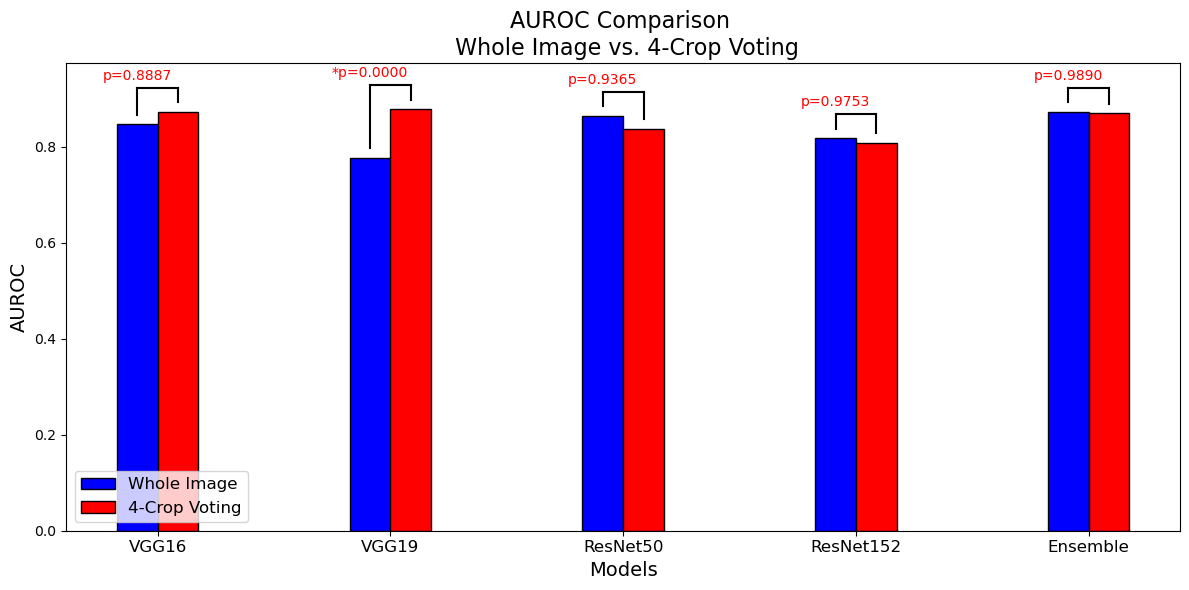

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def calculate_z_score(auroc1, auroc2, n1, n2):
    """
    Calculate the z-score for the difference in AUROC scores using sample sizes.
    """
    try:
        q1 = auroc1 / (2 - auroc1)
        q2 = 2 * (auroc1 ** 2) / (1 + auroc1)
        var1 = (auroc1 * (1 - auroc1) + (n1 - 1) * (q1 - auroc1 ** 2)) / n1
        var2 = (auroc2 * (1 - auroc2) + (n2 - 1) * (q2 - auroc2 ** 2)) / n2
        # Ensure variance is non-negative
        if var1 + var2 <= 0:
            return np.nan
        z_score = (auroc1 - auroc2) / np.sqrt(var1 + var2)
        return z_score
    except ZeroDivisionError:
        return np.nan

def calculate_p_value(z_score):
    """
    Calculate the p-value for a two-tailed z-test.
    """
    if np.isnan(z_score):
        return 0.0000  # If p-value is NaN, return 0.0000 as a fallback
    p_value = 2 * (1 - norm.cdf(abs(z_score)))
    return round(max(p_value, 1e-6), 4)  # Ensure p-value is rounded to 4 decimal places

# Input data: AUROC and sample sizes for the models
models = ['VGG16', 'VGG19', 'ResNet50', 'ResNet152', 'Ensemble']
sample_sizes = [127, 127, 127, 127, 127]
auroc_whole = [0.8468, 0.7771, 0.8639, 0.8179, 0.8731]
auroc_cropped = [0.8726, 0.8781, 0.8368, 0.8077, 0.8694]

# Calculate p-values for each model
p_values = []
for auroc1, auroc2, n1, n2 in zip(auroc_whole, auroc_cropped, sample_sizes, sample_sizes):
    z_score = calculate_z_score(auroc1, auroc2, n1, n2)
    p_value = calculate_p_value(z_score)
    p_values.append(p_value)

# Plotting the bar graph
x = np.arange(len(models)) * 2  # Add extra spacing between model groups
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width / 2, auroc_whole, width, label='Whole Image', color='blue', edgecolor='black')
bars2 = ax.bar(x + width / 2, auroc_cropped, width, label='4-Crop Voting', color='red', edgecolor='black')

# Add labels, title, and legend
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('AUROC', fontsize=14)
ax.set_title('AUROC Comparison \n Whole Image vs. 4-Crop Voting', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=12)
ax.legend(fontsize=12)

# Remove AUROC values on bars
# Annotate p-values
for i, (b1, b2) in enumerate(zip(bars1, bars2)):
    # p-value annotation
    y_max = max(b1.get_height(), b2.get_height())
    y_line = y_max + 0.05  # Line height for the top cap

    # Handle edge case where p-value is NaN or close to zero
    p_value = p_values[i]
    if p_value < 0.05:
        significance = '*'  # Add asterisk for significance
    else:
        significance = ''
    
    p_value_text = f'{significance}p={p_value:.4f}'

    # Draw connecting line with vertical caps
    ax.plot([b1.get_x() + b1.get_width() / 2, b1.get_x() + b1.get_width() / 2], [b1.get_height() + 0.02, y_line], 
            color='black', linewidth=1.5)  # Left vertical cap
    ax.plot([b2.get_x() + b2.get_width() / 2, b2.get_x() + b2.get_width() / 2], [b2.get_height() + 0.02, y_line], 
            color='black', linewidth=1.5)  # Right vertical cap
    ax.plot([b1.get_x() + b1.get_width() / 2, b2.get_x() + b2.get_width() / 2], [y_line, y_line], 
            color='black', linewidth=1.5)  # Horizontal line (top)

    # Annotate p-value above the line
    ax.text((b1.get_x() + b2.get_x()) / 2, y_line + 0.01,
            p_value_text, ha='center', va='bottom', fontsize=10, color='red')

# Adjust layout
plt.tight_layout()

# Save or show the plot
plt.savefig('auroc_comparison_with_p_values_final.png', dpi=300)
plt.show()


In [44]:
import pandas as pd
import numpy as np
from scipy import stats

# Function to calculate p-value using DeLong's test between two AUROC values
def calc_pvalue(auroc1, n1, auroc2, n2):
    auc_diff = abs(auroc1 - auroc2)
    se = np.sqrt((auroc1 * (1 - auroc1) / n1) + (auroc2 * (1 - auroc2) / n2))
    z_score = auc_diff / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
    return p_value

# Sample dataframes (replace with your actual DataFrame variables)
df = pd.DataFrame({
    'model': ['vgg16', 'resnet50', 'vgg19', 'resnet152', 'vgg16+vgg19'],
    'auroc': [0.8864, 0.8636, 0.8636, 0.8750, 0.8977]
})

# Number of samples
n_samples = 19

# Initialize an empty matrix for storing p-values
p_value_matrix = pd.DataFrame(np.zeros((len(df), len(df))), 
                              index=df['model'], columns=df['model'])

# Calculate the DeLong's test p-value for each pair of models
for i in range(len(df)):
    for j in range(i, len(df)):  # Only need to calculate for upper triangle
        if i == j:
            p_value_matrix.iloc[i, j] = np.nan  # Diagonal should be NaN
        else:
            # Get AUROC values for both models
            auroc1 = df.iloc[i]['auroc']
            auroc2 = df.iloc[j]['auroc']
            # Calculate the p-value for the current model pair
            p_val = calc_pvalue(auroc1, n_samples, auroc2, n_samples)
            p_value_matrix.iloc[i, j] = p_val
            p_value_matrix.iloc[j, i] = p_val  # Mirror the value for symmetry

# Output the p-value matrix
print(p_value_matrix)

# Optionally save to an Excel file
p_value_matrix.to_excel('Direct_delong_p_value_matrix.xlsx')


model           vgg16  resnet50     vgg19  resnet152  vgg16+vgg19
model                                                            
vgg16             NaN  0.831627  0.831627   0.913664     0.910621
resnet50     0.831627       NaN  1.000000   0.916965     0.745452
vgg19        0.831627  1.000000       NaN   0.916965     0.745452
resnet152    0.913664  0.916965  0.916965        NaN     0.825415
vgg16+vgg19  0.910621  0.745452  0.745452   0.825415          NaN


## Different sample number case

In [45]:
import numpy as np
from scipy import stats

# Function to calculate p-value using DeLong's test between two AUROC values
def calc_pvalue(auroc1, n1, auroc2, n2):
    auc_diff = abs(auroc1 - auroc2)
    se = np.sqrt((auroc1 * (1 - auroc1) / n1) + (auroc2 * (1 - auroc2) / n2))
    z_score = auc_diff / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
    return p_value

# Given AUROC values and sample sizes
auroc1 = 0.8426  # First AUROC value
n1 = 108         # Sample size for the first AUROC
auroc2 = 0.8864  # Second AUROC value
n2 = 19          # Sample size for the second AUROC

# Calculate the p-value
p_value = calc_pvalue(auroc1, n1, auroc2, n2)
print(f"p-value between AUROC {auroc1} (n={n1}) and AUROC {auroc2} (n={n2}): {p_value:.4f}")

p-value between AUROC 0.8426 (n=108) and AUROC 0.8864 (n=19): 0.5877


In [46]:
import pandas as pd
import numpy as np
from scipy import stats

# Function to calculate p-value using DeLong's test between two AUROC values
def calc_pvalue(auroc1, n1, auroc2, n2):
    auc_diff = abs(auroc1 - auroc2)
    se = np.sqrt((auroc1 * (1 - auroc1) / n1) + (auroc2 * (1 - auroc2) / n2))
    z_score = auc_diff / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
    return p_value

# Sample dataframes (replace with your actual DataFrame variables)
df = pd.DataFrame({
    'model': ['vgg16', 'resnet50', 'vgg19', 'resnet152', 'Ensemble_2'],
    'auroc': [0.8426, 0.7617, 0.8668, 0.8063, 0.8727]
})

# Number of samples
n_samples = 127

# Initialize an empty matrix for storing p-values
p_value_matrix = pd.DataFrame(np.zeros((len(df), len(df))), 
                              index=df['model'], columns=df['model'])

# Calculate the DeLong's test p-value for each pair of models
for i in range(len(df)):
    for j in range(i, len(df)):  # Only need to calculate for upper triangle
        if i == j:
            p_value_matrix.iloc[i, j] = np.nan  # Diagonal should be NaN
        else:
            # Get AUROC values for both models
            auroc1 = df.iloc[i]['auroc']
            auroc2 = df.iloc[j]['auroc']
            # Calculate the p-value for the current model pair
            p_val = calc_pvalue(auroc1, n_samples, auroc2, n_samples)
            p_value_matrix.iloc[i, j] = p_val
            p_value_matrix.iloc[j, i] = p_val  # Mirror the value for symmetry

# Output the p-value matrix
print(p_value_matrix)

# Optionally save to an Excel file
p_value_matrix.to_excel('delong_p_value_matrix.xlsx')


model          vgg16  resnet50     vgg19  resnet152  Ensemble_2
model                                                          
vgg16            NaN  0.103815  0.584005   0.446530    0.492017
resnet50    0.103815       NaN  0.029747   0.387083    0.020750
vgg19       0.584005  0.029747       NaN   0.190818    0.888904
resnet152   0.446530  0.387083  0.190818        NaN    0.147783
Ensemble_2  0.492017  0.020750  0.888904   0.147783         NaN
